In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 数据获取及预处理

In [2]:
data_folder = 'data'

futures_list = [
    "A.DCE", "AG.SHF", "AL.SHF", "AO.SHF", "AP.CZC", "AU.SHF", "B.DCE", "BB.DCE", 
    "BR.SHF", "BU.SHF", "C.DCE", "CF.CZC", "CJ.CZC", "CS.DCE", "CU.SHF", 
    "CY.CZC", "EB.DCE", "EG.DCE", "FB.DCE", "FG.CZC", "FU.SHF", "HC.SHF", "I.DCE", 
    "JD.DCE", "JM.DCE", "JR.CZC", "L.DCE", "LH.DCE", "LR.CZC",
    "M.DCE", "MA.CZC", "NI.SHF", "NR.INE", "OI.CZC", "P.DCE", "PB.SHF",
    "PF.CZC", "PG.DCE", "PK.CZC", "PM.CZC", "PP.DCE", "PX.CZC", "RB.SHF", "RI.CZC",
    "RM.CZC", "RR.DCE", "RS.CZC", "RU.SHF", "SA.CZC", "SF.CZC",
    "SH.CZC", "SM.CZC", "SN.SHF", "SP.SHF", "SR.CZC", "SS.SHF",
    "TA.CZC", "UR.CZC", "V.DCE", "WH.CZC", "WR.SHF", "Y.DCE", "ZC.CZC", "ZN.SHF"
]

for future in futures_list:
    file_name = os.path.join(data_folder, future.replace('.', '_') + "_df.csv")
    if os.path.exists(file_name):
        df = pd.read_csv(file_name, index_col=0, encoding='utf-8')
        variable_name = future.replace('.', '_') + "_df"
        globals()[variable_name] = df

missing_values_summary = {}

def check_missing_values(df, future_name):
    missing_values = df.isna().sum().sum()
    if missing_values > 0:
        missing_values_summary[future_name] = missing_values

for future in futures_list:
    variable_name = future.replace('.', '_') + "_df"
    df = globals().get(variable_name, None)
    check_missing_values(df, future)
    
for future in missing_values_summary.keys():
    variable_name = future.replace('.', '_') + "_df"
    if variable_name in globals():
        del globals()[variable_name]

new_list = []
# 如果变量在全局变量中存在，说明没有被删除，添加到 new_list
for future in futures_list:
    variable_name = future.replace('.', '_') + "_df"
    if variable_name in globals():
        new_list.append(future)

missing_values_summary.clear()

# 在 new_list 中检查是否还有缺失值
for future in new_list:
    variable_name = future.replace('.', '_') + "_df"
    df = globals().get(variable_name, None)
    if df is not None:
        check_missing_values(df, future)

if missing_values_summary:
    print("存在缺失值的期货合约：", missing_values_summary)
else:
    print("所有数据无缺失值")

所有数据无缺失值


# 交易配对品种选择

## 收盘价序列观察

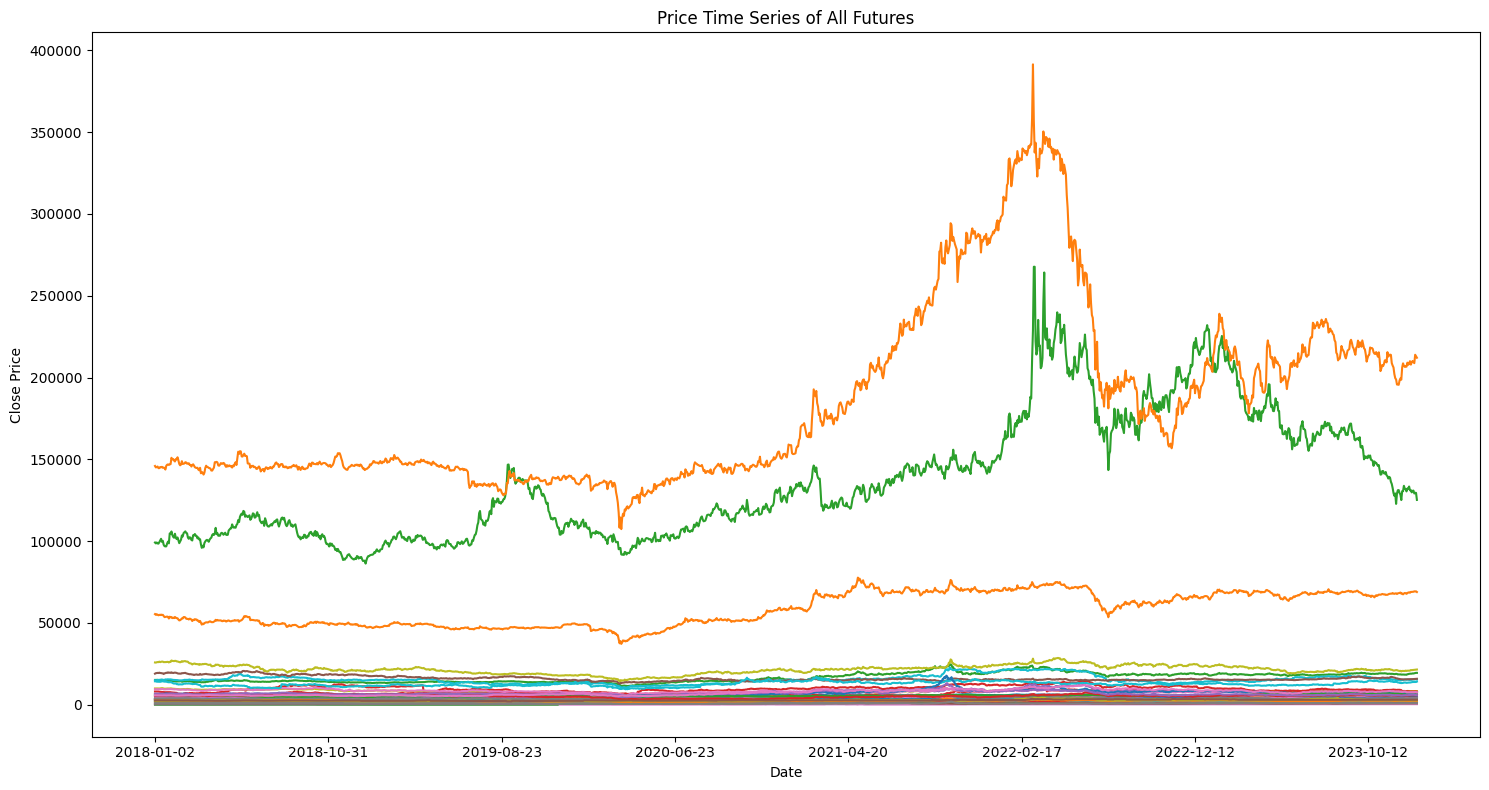

In [3]:
def plot_time_series(df, future_name, ax):
    df['CLOSE'].plot(ax=ax, label=future_name)

plt.figure(figsize=(15, 8))
for future in new_list:
    variable_name = future.replace('.', '_') + "_df"
    df = globals().get(variable_name, None)
    if df is not None:
        plot_time_series(df, future, plt.gca())

plt.title("Price Time Series of All Futures")
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


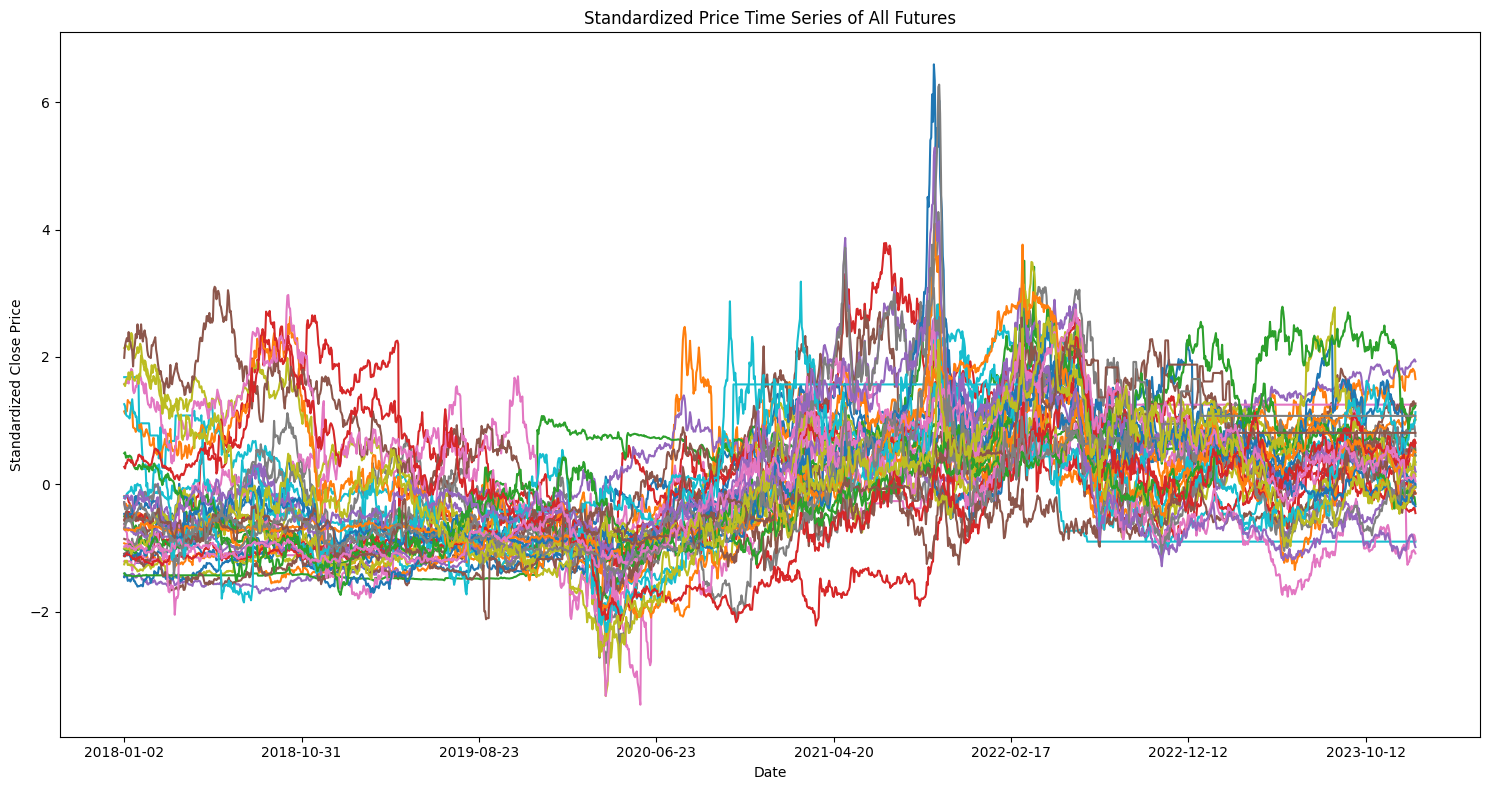

In [4]:
# 归一化后时间序列
def standardize_series(series):
    return (series - series.mean()) / series.std()
plt.figure(figsize=(15, 8))
for future in new_list:
    variable_name = future.replace('.', '_') + "_df"
    df = globals().get(variable_name, None)
    
    if df is not None:
        standardized_price = standardize_series(df['CLOSE'])
        standardized_price.plot(label=future)

plt.title("Standardized Price Time Series of All Futures")
plt.ylabel('Standardized Close Price')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

## 主成分分析

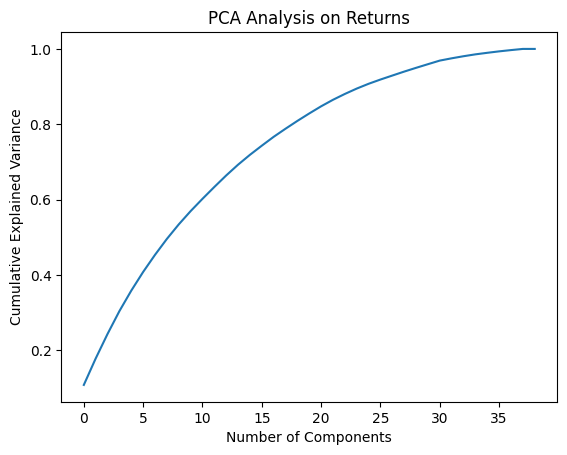

Optimal number of components based on returns:  24
Most representative dates based on PCA of returns:
Principal Component 1 : 2022-05-18
Principal Component 2 : 2023-08-25
Principal Component 3 : 2020-03-09
Principal Component 4 : 2018-12-26
Principal Component 5 : 2019-09-16
Principal Component 6 : 2022-06-22
Principal Component 7 : 2021-09-24
Principal Component 8 : 2018-05-15
Principal Component 9 : 2023-06-21
Principal Component 10 : 2021-12-01
Principal Component 11 : 2019-10-18
Principal Component 12 : 2020-08-10
Principal Component 13 : 2022-02-25
Principal Component 14 : 2022-10-10
Principal Component 15 : 2020-06-16
Principal Component 16 : 2021-10-28
Principal Component 17 : 2019-08-22
Principal Component 18 : 2022-03-09
Principal Component 19 : 2023-01-11
Principal Component 20 : 2018-12-05
Principal Component 21 : 2018-03-01
Principal Component 22 : 2019-11-26
Principal Component 23 : 2023-02-14
Principal Component 24 : 2018-12-24


In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

dataframes = []

for future in new_list:
    variable_name = future.replace('.', '_') + "_df"
    df = globals().get(variable_name, None)
    if df is not None:
        returns = df[['CLOSE']].pct_change().dropna()
        dataframes.append(returns.rename(columns={'CLOSE': future}))

combined_df = pd.concat([df.iloc[:, 0] for df in dataframes], axis=1)
combined_df.columns = new_list
combined_df_transposed = combined_df.T

scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_df_transposed)


pca = PCA()
principalComponents = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_.cumsum()
optimal_components = np.argmax(explained_variance > 0.9)

plt.figure()
plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis on Returns')
plt.show()

print("Optimal number of components based on returns: ", optimal_components)
print("Most representative dates based on PCA of returns:")
for i in range(optimal_components):
    sorted_indices = np.argsort(np.abs(pca.components_[i]))[::-1]
    print("Principal Component", i+1, ":", combined_df_transposed.columns[sorted_indices[0]])


## OPTICS聚类

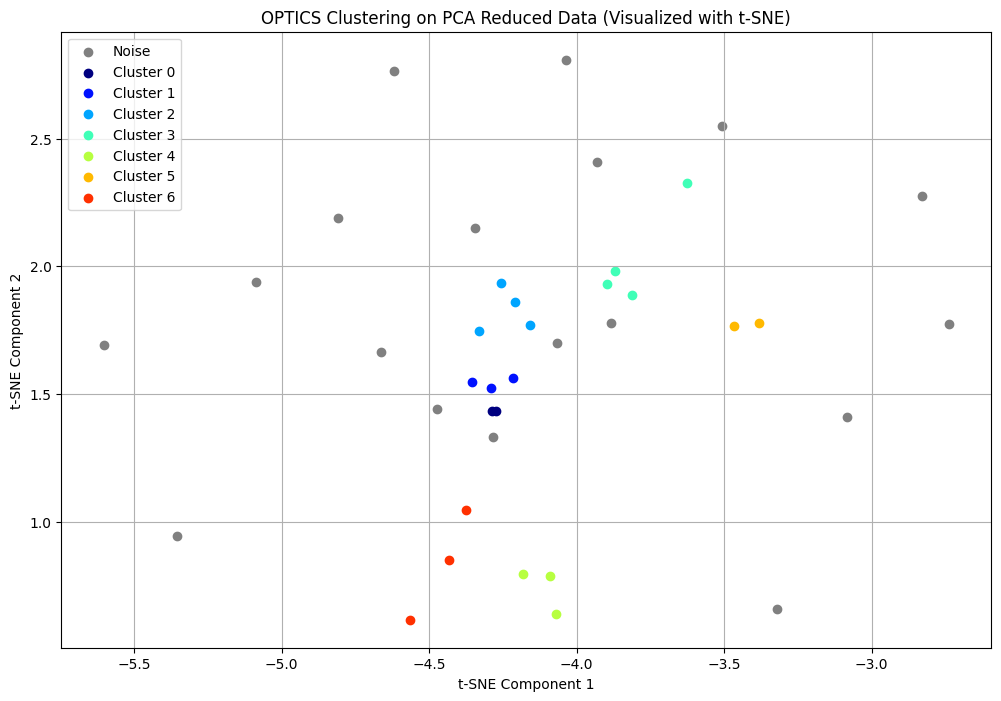

In [6]:
from sklearn.cluster import OPTICS
from statsmodels.tsa.stattools import coint
pca = PCA(n_components=13)
principalComponents = pca.fit_transform(scaled_data)


optics_model = OPTICS(min_samples=2)
clusters = optics_model.fit_predict(principalComponents)

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 使用t-SNE进一步降维到2维
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(principalComponents)
plt.figure(figsize=(12, 8))
for cluster_label in np.unique(clusters):
    subset = tsne_result[clusters == cluster_label]
    if cluster_label == -1:  # 噪声点
        color = 'gray'
        label = 'Noise'
    else:
        color = plt.cm.jet(float(cluster_label) / np.max(clusters + 1))
        label = f"Cluster {cluster_label}"
    plt.scatter(subset[:, 0], subset[:, 1], c=[color], label=label)

plt.title('OPTICS Clustering on PCA Reduced Data (Visualized with t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# 查看详细的聚类簇
clustered_series = pd.Series(index=combined_df_transposed.index, data=clusters.flatten())
clustered_series = clustered_series[clustered_series != -1]  # 去除噪声
cluster_contents = {}
for cluster_num in clustered_series.unique():
    members = clustered_series[clustered_series == cluster_num].index.tolist()
    cluster_contents[cluster_num] = members
for cluster, futures in cluster_contents.items():
    print(f"Cluster {cluster}:")
    for future in futures:
        print(f" - {future}")
    print("\n")

Cluster 2:
 - AL.SHF
 - CU.SHF
 - PB.SHF
 - ZN.SHF


Cluster 4:
 - B.DCE
 - M.DCE
 - RM.CZC


Cluster 0:
 - C.DCE
 - CS.DCE


Cluster 5:
 - HC.SHF
 - RB.SHF


Cluster 3:
 - L.DCE
 - MA.CZC
 - PP.DCE
 - V.DCE


Cluster 1:
 - LR.CZC
 - SR.CZC
 - WH.CZC


Cluster 6:
 - OI.CZC
 - P.DCE
 - Y.DCE




## 网络模型搭建

In [8]:
import networkx as nx

def calculate_daily_volatility(df):
    daily_range = df['HIGH'] - df['LOW']
    return (2 * daily_range) / (df['HIGH'] + df['LOW'])

def network(new_list, threshold = 0.1):
    volatility_dataframes = []
    for future in new_list:
        variable_name = future.replace('.', '_') + "_df"
        df = globals().get(variable_name, None)
        df['volatility'] = calculate_daily_volatility(df)
        volatility_dataframes.append(df[['volatility']].rename(columns={'volatility': future}))
        
    volatility_df = pd.concat(volatility_dataframes, axis=1)
    correlation_matrix = volatility_df.corr()
    graph = nx.Graph()

    for i in range(len(correlation_matrix)):
        for j in range(i+1, len(correlation_matrix)):
            if correlation_matrix.iloc[i, j] > threshold:
                graph.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j])

    degrees = dict(graph.degree())
    sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

    # 选择度最高的节点数量
    top_n = 5
    central_nodes = sorted_nodes[:top_n]
    neighbors = set(central_nodes)
    for node in central_nodes:
        neighbors.update(graph.neighbors(node))
    subgraph = graph.subgraph(neighbors)
    pos = nx.spring_layout(subgraph, seed=42) # 可以尝试不同的布局算法
    nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.show()

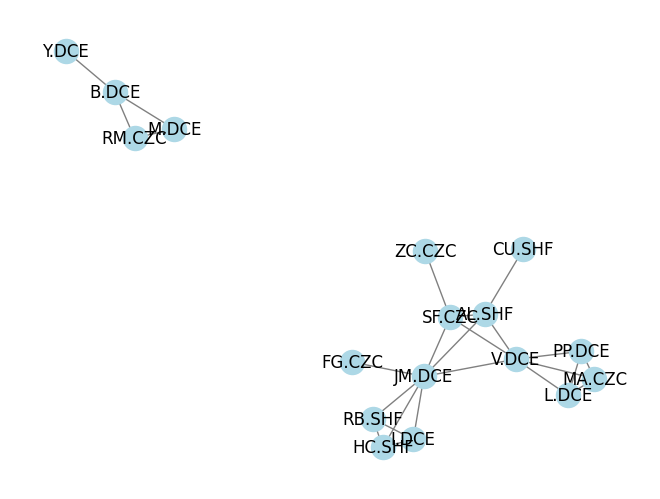

In [9]:
network(new_list, threshold = 0.5)

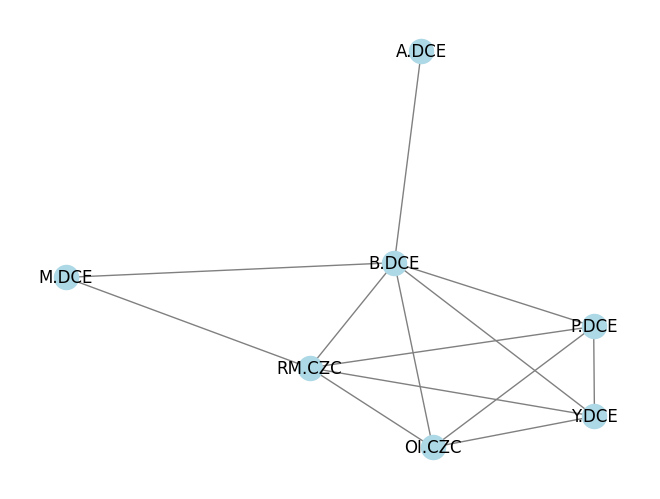

In [10]:
# 农产品期货
farm_list = [
    "A.DCE", "AP.CZC", "B.DCE", "CF.CZC",  # 黄大豆1号、苹果、黄大豆2号、棉花
    "C.DCE", "CS.DCE", "JD.DCE", "LR.CZC",  # 玉米、玉米淀粉、鸡蛋、晚籼稻
    "M.DCE", "OI.CZC", "P.DCE", "RM.CZC",  # 豆粕、菜籽油、棕榈油、菜籽粕
    "SR.CZC", "WH.CZC", "Y.DCE", "ZC.CZC"  # 白糖、强麦、豆油、动力煤
]

# 有色金属期货
nonferrous_metal_list = [
    "AL.SHF", "CU.SHF", "NI.SHF", "PB.SHF",  # 铝、铜、镍、铅
    "SN.SHF", "ZN.SHF"  # 锡、锌
]

# 贵金属期货
precious_metal_list = [
    "AU.SHF", "AG.SHF"  # 黄金、白银
]

# 能源化工期货
energy_chemical_list = [
    "BU.SHF", "RU.SHF", "FG.CZC", "HC.SHF",  # 石油沥青、天然橡胶、玻璃、热轧卷板
    "L.DCE", "PP.DCE", "SF.CZC"  # 聚乙烯、聚丙烯、硅铁
]

# 黑色金属期货
ferrous_metal_list = [
    "I.DCE", "RB.SHF", "JM.DCE", "J.DCE"  # 铁矿石、螺纹钢、焦煤、焦炭
]

network(farm_list, threshold = 0.4)

## 协整性检验

In [11]:
# 依据聚类分析和网格模型得到的期货对
futures_pairs = [
    ("CU.SHF", "AL.SHF"),
    ("AL.SHF", "ZN.SHF"),
    ("CU.SHF", "ZN.SHF"),
    ("B.DCE", "M.DCE"),
    ("B.DCE", "RM.CZC"),
    ("M.DCE", "RM.CZC"),
    ("OI.CZC", "P.DCE"),
    ("OI.CZC", "Y.DCE"),
    ("P.DCE", "Y.DCE")
]

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller, coint

# ADF平稳性检验
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    return p_value  

# 协整性检验
def coint_test(series1, series2):
    score, p_value, _ = coint(series1, series2)
    return p_value 

# 回归残差
def calculate_residuals(df1, df2):
    close1 = df1['CLOSE']
    close2 = df2['CLOSE']
    
    X = close1.values.reshape(-1, 1)
    y = close2.values
    
    model = LinearRegression()
    model.fit(X, y)
    predicted = model.predict(X)
    
    residuals = close2 - predicted
    slope = model.coef_[0]
      
    return residuals, close1 - close2, slope

def check_and_plot(futures_pairs):

    for i, (future1, future2) in enumerate(futures_pairs):
        df1 = globals().get(future1.replace('.', '_') + "_df")
        df2 = globals().get(future2.replace('.', '_') + "_df")
        
        residuals, spread, _ = calculate_residuals(df1, df2)
        
        adf_p_spread = adf_test(spread) 
        adf_p_residuals = adf_test(residuals)  
        coint_p = coint_test(df1['CLOSE'], df2['CLOSE']) 

        print(f"\n{future1} 和 {future2} 的价格差的ADF检验p值: {adf_p_spread:.4f}", end=' ')
        if adf_p_spread < 0.05:
            print("(价格差平稳)")
        else:
            print("(价格差不平稳)")

        print(f"{future1} 和 {future2} 的回归残差的ADF检验p值: {adf_p_residuals:.4f}", end=' ')
        if adf_p_residuals < 0.05:
            print("(回归残差平稳)")
        else:
            print("(回归残差不平稳)")

        print(f"{future1} 和 {future2} 的协整检验p值: {coint_p:.4f}", end=' ')
        if coint_p < 0.05:
            print("(期货对有协整关系，适合均值回复策略)")
        else:
            print("(期货对没有协整关系)")

check_and_plot(futures_pairs)



CU.SHF 和 AL.SHF 的价格差的ADF检验p值: 0.6696 (价格差不平稳)
CU.SHF 和 AL.SHF 的回归残差的ADF检验p值: 0.0001 (回归残差平稳)
CU.SHF 和 AL.SHF 的协整检验p值: 0.0012 (期货对有协整关系，适合均值回复策略)

AL.SHF 和 ZN.SHF 的价格差的ADF检验p值: 0.0971 (价格差不平稳)
AL.SHF 和 ZN.SHF 的回归残差的ADF检验p值: 0.0590 (回归残差不平稳)
AL.SHF 和 ZN.SHF 的协整检验p值: 0.5178 (期货对没有协整关系)

CU.SHF 和 ZN.SHF 的价格差的ADF检验p值: 0.7742 (价格差不平稳)
CU.SHF 和 ZN.SHF 的回归残差的ADF检验p值: 0.0837 (回归残差不平稳)
CU.SHF 和 ZN.SHF 的协整检验p值: 0.7809 (期货对没有协整关系)

B.DCE 和 M.DCE 的价格差的ADF检验p值: 0.1385 (价格差不平稳)
B.DCE 和 M.DCE 的回归残差的ADF检验p值: 0.0001 (回归残差平稳)
B.DCE 和 M.DCE 的协整检验p值: 0.0016 (期货对有协整关系，适合均值回复策略)

B.DCE 和 RM.CZC 的价格差的ADF检验p值: 0.3667 (价格差不平稳)
B.DCE 和 RM.CZC 的回归残差的ADF检验p值: 0.0024 (回归残差平稳)
B.DCE 和 RM.CZC 的协整检验p值: 0.0315 (期货对有协整关系，适合均值回复策略)

M.DCE 和 RM.CZC 的价格差的ADF检验p值: 0.0185 (价格差平稳)
M.DCE 和 RM.CZC 的回归残差的ADF检验p值: 0.0182 (回归残差平稳)
M.DCE 和 RM.CZC 的协整检验p值: 0.0647 (期货对没有协整关系)

OI.CZC 和 P.DCE 的价格差的ADF检验p值: 0.0524 (价格差不平稳)
OI.CZC 和 P.DCE 的回归残差的ADF检验p值: 0.0297 (回归残差平稳)
OI.CZC 和 P.DCE 的协整检验p值: 0.1039 (期货对没有协整关系)

OI.CZC 和 Y.DCE 的价格差的ADF

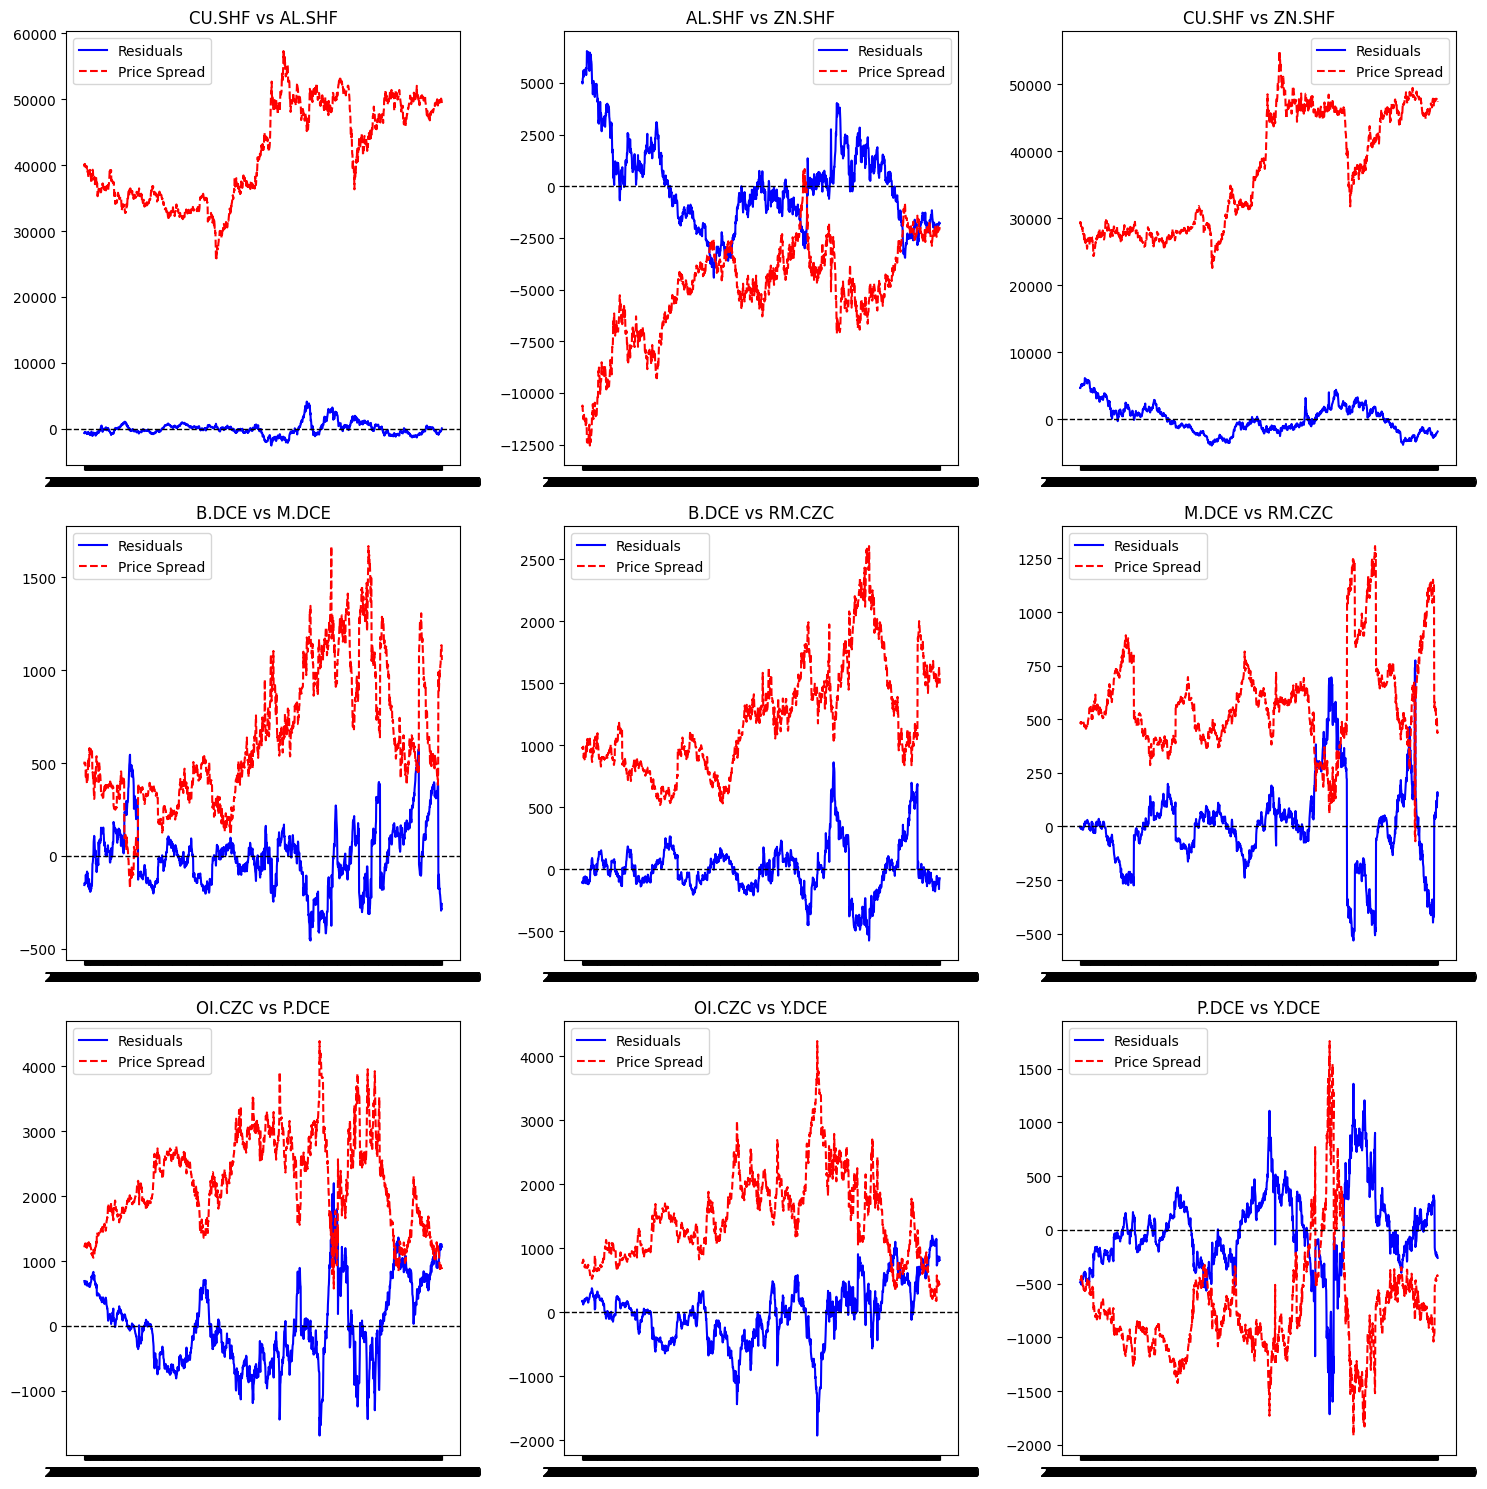

In [12]:
# 对期货对进行平稳性、协整性检验并绘制图表
def check_and_plot(futures_pairs):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 创建3x3的子图
    axes = axes.flatten()

    for i, (future1, future2) in enumerate(futures_pairs):
        df1 = globals().get(future1.replace('.', '_') + "_df")
        df2 = globals().get(future2.replace('.', '_') + "_df")
        
        residuals, spread, _ = calculate_residuals(df1, df2)
        
        ax = axes[i]
        ax.plot(df1.index, residuals, label='Residuals', color='blue')
        ax.plot(df1.index, spread, label='Price Spread', color='red', linestyle='--')
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)  # 添加均值线
        ax.set_title(f'{future1} vs {future2}')
        ax.legend()

    plt.tight_layout()  
    plt.show()

check_and_plot(futures_pairs)


# Pair-trading

## 时变标准差阈值

In [13]:
selected_pairs = [
    ("CU.SHF", "AL.SHF"),
    ("B.DCE", "M.DCE"),
    ("B.DCE", "RM.CZC"),
    ("P.DCE", "Y.DCE")
]

In [14]:
# 回测指标函数
def calculate_performance_metrics(net_value, risk_free_rate=0.03):
    net_value = np.array(net_value)
    returns = np.diff(net_value) / net_value[:-1]

    # 年化收益率
    total_return = (net_value[-1] / net_value[0]) - 1
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1
    
    # 最大回撤
    drawdowns = np.maximum.accumulate(net_value) - net_value
    max_drawdown = np.max(drawdowns) / np.maximum.accumulate(net_value).max()
    
    # 夏普比率
    excess_returns = returns - risk_free_rate / 252
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    
    return {
        'annual_return': annual_return,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio
    }


In [15]:
import matplotlib.dates as mdates

def plot_residuals_with_trades(future1, future2, window_size, n, net_value, entry_points, exit_points):
    df1 = globals().get(future1.replace('.', '_') + "_df")
    df2 = globals().get(future2.replace('.', '_') + "_df")
    residuals, _, _ = calculate_residuals(df1, df2)
    
    residuals.index = pd.to_datetime(residuals.index)
    mean_residuals = residuals.rolling(window=window_size).mean()
    std_residuals = residuals.rolling(window=window_size).std()

    plt.figure(figsize=(12, 6))
    plt.plot(residuals.index, residuals, label='Residuals', color='blue', alpha=0.6)
    plt.plot(mean_residuals.index, mean_residuals, label='Rolling Mean', color='black')
    plt.plot(mean_residuals.index, mean_residuals + n * std_residuals, label=f'Upper {n}σ', color='red', linestyle='--')
    plt.plot(mean_residuals.index, mean_residuals - n * std_residuals, label=f'Lower {n}σ', color='green', linestyle='--')
    
    entry_dates = df1.index[entry_points]
    exit_dates = df1.index[exit_points]

    plt.scatter(entry_dates, residuals.loc[entry_dates], color='red', marker='^', label='Entry Points', zorder=5)
    plt.scatter(exit_dates, residuals.loc[exit_dates], color='green', marker='v', label='Exit Points', zorder=5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) #每3个月输出一次
    plt.gcf().autofmt_xdate()  

    plt.title(f"Residuals with Trading Points for {future1} and {future2}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
def backtest(future1, future2, initial_capital, window_size, n, ifplot = False):
    df1 = globals().get(future1.replace('.', '_') + "_df")
    df2 = globals().get(future2.replace('.', '_') + "_df")
    
    capital = initial_capital
    position = 0  
    entry_price1, entry_price2 = 0, 0  
    net_value = [capital]
    entry_points = []
    exit_points = []
    trades = []  

    residuals, spread, alpha = calculate_residuals(df1, df2)
    
    for i in range(window_size, len(residuals)):
        window_residuals = residuals.iloc[i-window_size:i]
        mean_residual = np.mean(window_residuals)
        std_residual = np.std(window_residuals)
        current_residual = residuals.iloc[i]
        
        # 如果期货合约发生变化，强制平仓
        if df1['TRADE_HISCODE'].iloc[i] != df1['TRADE_HISCODE'].iloc[i-1] or df2['TRADE_HISCODE'].iloc[i] != df2['TRADE_HISCODE'].iloc[i-1]:
            if position != 0: 
                trade_profit = position * (alpha * (df1['CLOSE'].iloc[i] - entry_price1) + (entry_price2 - df2['CLOSE'].iloc[i]))
                capital += trade_profit
                exit_points.append(i)
                
                trades.append({
                    'entry_date': df1.index[entry_points[-1]],
                    'exit_date': df1.index[i],
                    'entry_price1': entry_price1,
                    'entry_price2': entry_price2,
                    'exit_price1': df1['CLOSE'].iloc[i],
                    'exit_price2': df2['CLOSE'].iloc[i],
                    'position': position,
                    'profit': trade_profit
                })
                
                position = 0
            net_value.append(capital)
            continue 
        
        # 开平仓逻辑
        if position == 0:
            if current_residual > mean_residual + n * std_residual:
                # 做多价低，做空价高
                entry_price1, entry_price2 = df1['CLOSE'].iloc[i], df2['CLOSE'].iloc[i]
                position = 1
                entry_points.append(i)
            elif current_residual < mean_residual - n * std_residual:
                # 做空价低，做多价高
                entry_price1, entry_price2 = df1['CLOSE'].iloc[i], df2['CLOSE'].iloc[i]
                position = -1
                entry_points.append(i)
        elif position != 0:
            if mean_residual - 0.05 * std_residual <= current_residual <= mean_residual + 0.05 * std_residual:
                trade_profit = position * (alpha * (df1['CLOSE'].iloc[i] - entry_price1) + (entry_price2 - df2['CLOSE'].iloc[i]))
                capital += trade_profit
                position = 0
                exit_points.append(i)
                
                trades.append({
                    'entry_date': df1.index[entry_points[-1]],
                    'exit_date': df1.index[i],
                    'entry_price1': entry_price1,
                    'entry_price2': entry_price2,
                    'exit_price1': df1['CLOSE'].iloc[i],
                    'exit_price2': df2['CLOSE'].iloc[i],
                    'position': position,
                    'profit': trade_profit
                })
            net_value.append(capital)
    
    if ifplot == True:
        plot_residuals_with_trades(future1, future2, window_size, n, net_value, entry_points, exit_points)
    return net_value, trades 


In [17]:
import random

def random_search(selected_pairs, initial_capital, window_range, n_range, num_trials=50):
    best_params = {} 
    best_performance = {} 

    for future1, future2 in selected_pairs:
        best_annual_return = -float('inf')  # 初始化最佳年化收益率
        best_combination = None

        for _ in range(num_trials):
            window_size = random.choice(window_range)
            n = round(random.choice(n_range), 2)
            net_value, trades = backtest(future1, future2, initial_capital, window_size, n)
            performance = calculate_performance_metrics(net_value)
            annual_return = performance['annual_return']
            if annual_return > best_annual_return:
                best_annual_return = annual_return
                best_combination = (window_size, n)
                best_performance[(future1, future2)] = performance

        best_params[(future1, future2)] = best_combination
    
    return best_params, best_performance

n_range = np.arange(1, 5, 0.1) 
window_range = np.arange(10, 60, 5)
initial_capital = 100000

num_trials = 50  
best_params, best_performance = random_search(selected_pairs, initial_capital, window_range, n_range, num_trials)

for pair, params in best_params.items():
    print(f"\n期货对: {pair} 的最佳参数: window_size={params[0]}, n={params[1]}")
    print(f"绩效指标: 年化收益率: {best_performance[pair]['annual_return']:.2%}, "
          f"最大回撤: {best_performance[pair]['max_drawdown']:.2%}, "
          f"夏普比率: {best_performance[pair]['sharpe_ratio']:.2f}")



期货对: ('CU.SHF', 'AL.SHF') 的最佳参数: window_size=10, n=3.9
绩效指标: 年化收益率: 4.01%, 最大回撤: 1.03%, 夏普比率: 0.44

期货对: ('B.DCE', 'M.DCE') 的最佳参数: window_size=45, n=1.0
绩效指标: 年化收益率: 0.90%, 最大回撤: 0.37%, 夏普比率: -3.31

期货对: ('B.DCE', 'RM.CZC') 的最佳参数: window_size=10, n=2.8
绩效指标: 年化收益率: 0.50%, 最大回撤: 0.65%, 夏普比率: -5.76

期货对: ('P.DCE', 'Y.DCE') 的最佳参数: window_size=55, n=4.0
绩效指标: 年化收益率: 1.28%, 最大回撤: 0.00%, 夏普比率: -3.13


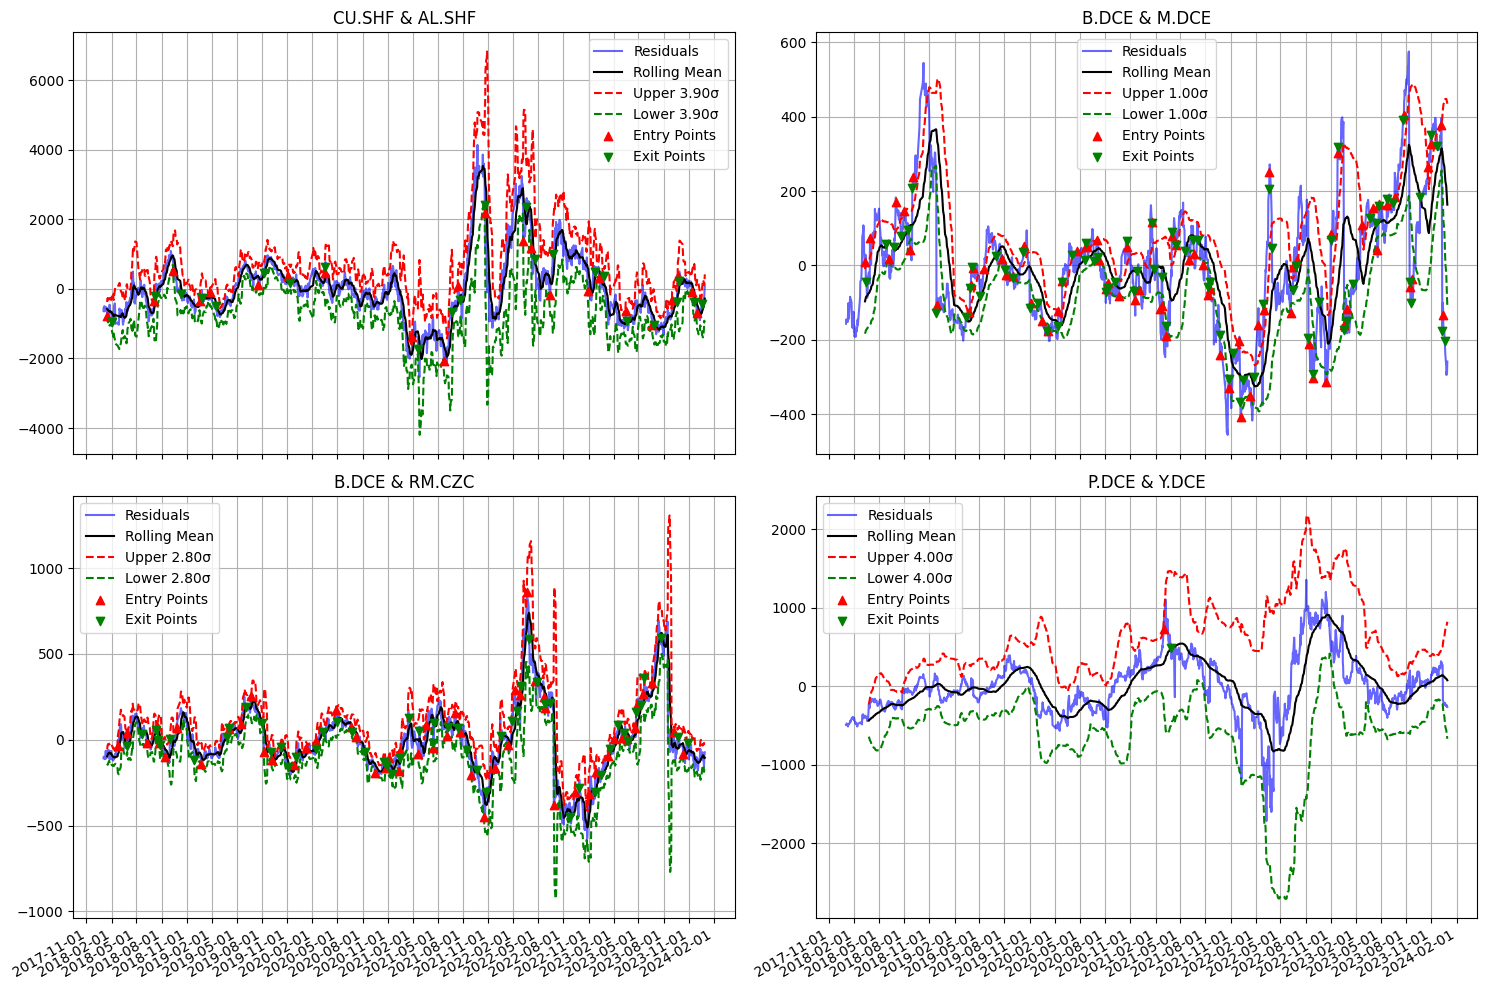

In [18]:
def run_backtest_and_plot(selected_pairs, initial_capital, best_params):
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
    axes = axes.flatten()  

    for i, (pair, params) in enumerate(best_params.items()):
        future1, future2 = pair
        window_size = params[0]
        n = params[1]
        net_value, trades = backtest(future1, future2, initial_capital, window_size, n)
        df1 = globals().get(future1.replace('.', '_') + "_df")
        df2 = globals().get(future2.replace('.', '_') + "_df")
        residuals, _, _ = calculate_residuals(df1, df2)
        mean_residuals = residuals.rolling(window=window_size).mean()
        std_residuals = residuals.rolling(window=window_size).std()
        
        residuals.index = pd.to_datetime(residuals.index)

        ax = axes[i]
        ax.plot(residuals.index, residuals, label='Residuals', color='blue', alpha=0.6)
        ax.plot(residuals.index, mean_residuals, label='Rolling Mean', color='black')
        ax.plot(residuals.index, mean_residuals + n * std_residuals, 
                label=f'Upper {n:.2f}σ', color='red', linestyle='--')
        ax.plot(residuals.index, mean_residuals - n * std_residuals, 
                label=f'Lower {n:.2f}σ', color='green', linestyle='--')

        entry_points = [t['entry_date'] for t in trades]
        exit_points = [t['exit_date'] for t in trades]
        ax.scatter(entry_points, residuals.loc[entry_points], color='red', marker='^', label='Entry Points', zorder=5)
        ax.scatter(exit_points, residuals.loc[exit_points], color='green', marker='v', label='Exit Points', zorder=5)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        fig.autofmt_xdate()

        ax.set_title(f"{future1} & {future2}")
        ax.legend()
        ax.grid(True)
        
    plt.tight_layout()
    plt.show()

run_backtest_and_plot(selected_pairs, initial_capital, best_params)


## Garch模型标准差阈值


=== Analyzing pair: CU.SHF & AL.SHF ===
AR(1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                 1564
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -11218.665
Date:                 周二, 22 10月 2024   AIC                          22443.329
Time:                        15:04:18   BIC                          22459.394
Sample:                    01-02-2018   HQIC                         22449.302
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.178e+04   5123.128      8.156      0.000    3.17e+04    5.18e+04
ar.L1          0.9973      0.002    551.838      0.000       0.994   

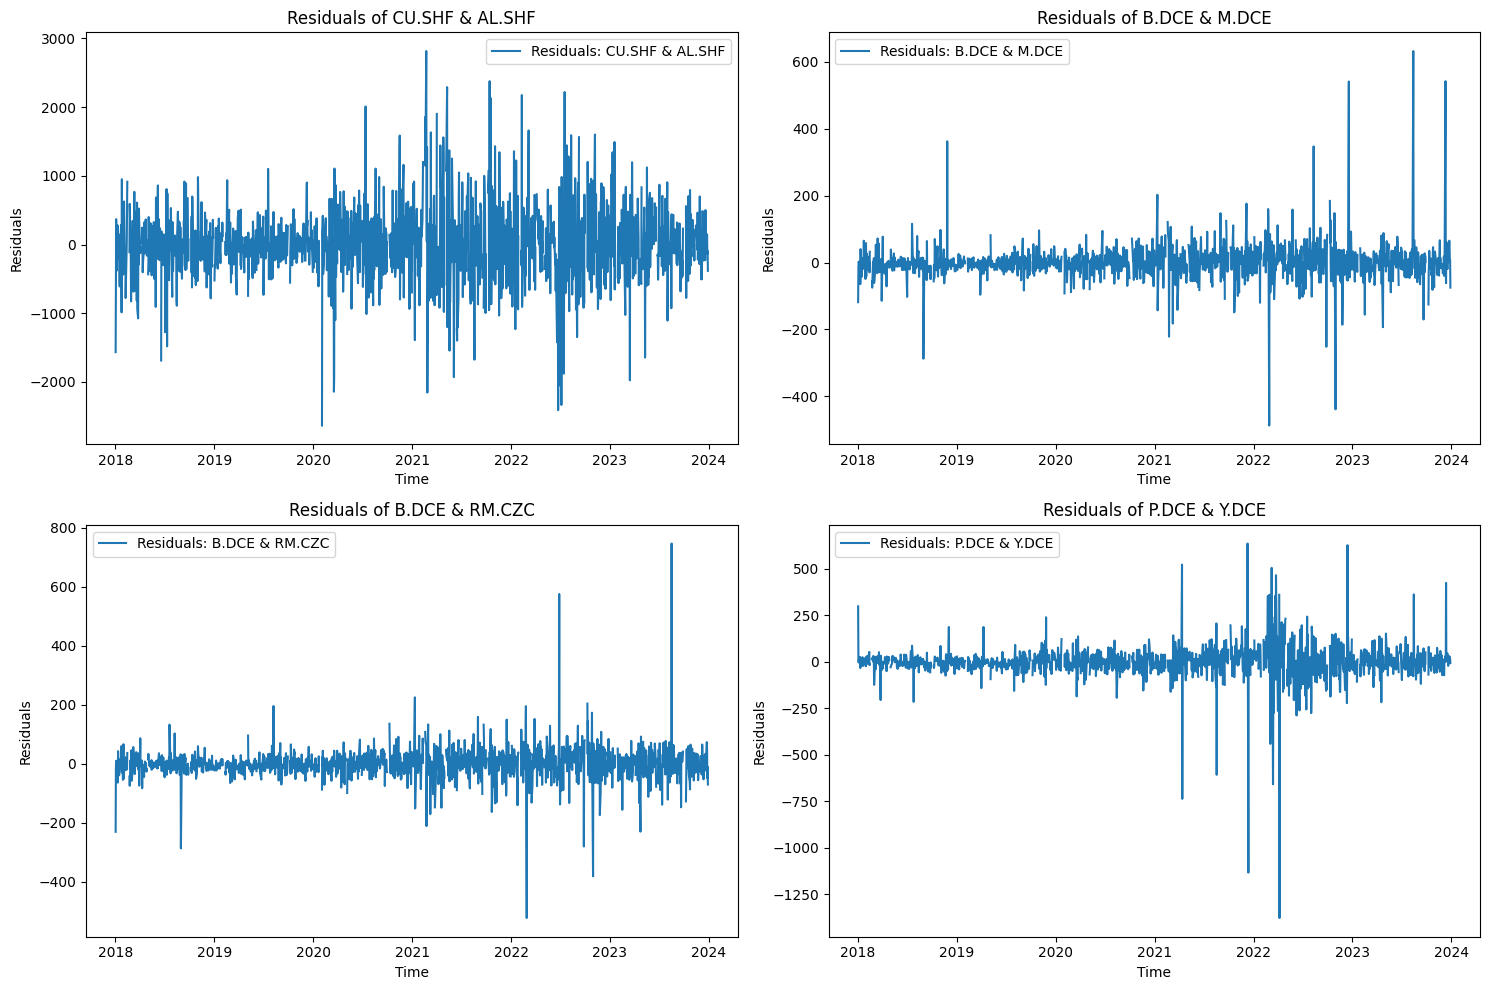

In [30]:
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

def get_spread_series(future1, future2):
    df1 = globals().get(future1.replace('.', '_') + "_df")
    df2 = globals().get(future2.replace('.', '_') + "_df")
    _, spread, _ = calculate_residuals(df1, df2)
    spread.index = pd.to_datetime(spread.index) 
    spread = spread.asfreq('B') 
    return spread

# AR(1)
def fit_ar_model(spread):
    model = ARIMA(spread, order=(1, 0, 0))  
    result = model.fit()
    print("AR(1) Model Summary:")
    print(result.summary())
    return result

def plot_residuals_in_grid(selected_pairs, residuals_list):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
    axes = axes.flatten()

    for i, (pair, residuals) in enumerate(zip(selected_pairs, residuals_list)):
        future1, future2 = pair
        axes[i].plot(residuals, label=f'Residuals: {future1} & {future2}')
        axes[i].set_title(f'Residuals of {future1} & {future2}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Residuals')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def run_arima_for_all(selected_pairs):
    residuals_list = []
    for future1, future2 in selected_pairs:
        print(f"\n=== Analyzing pair: {future1} & {future2} ===")
        try:
            spread = get_spread_series(future1, future2)
            
            ar_result = fit_ar_model(spread)
            residuals = ar_result.resid
            residuals_list.append(residuals) 
        except Exception as e:
            print(f"Error processing {future1} & {future2}: {e}")
            residuals_list.append(np.zeros(len(spread))) 

    plot_residuals_in_grid(selected_pairs, residuals_list)

run_arima_for_all(selected_pairs)


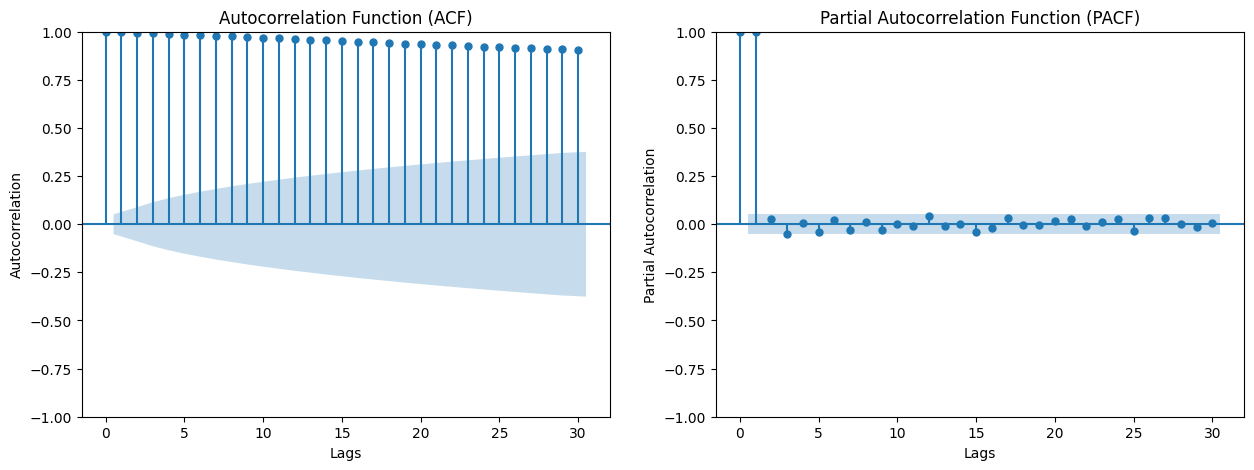

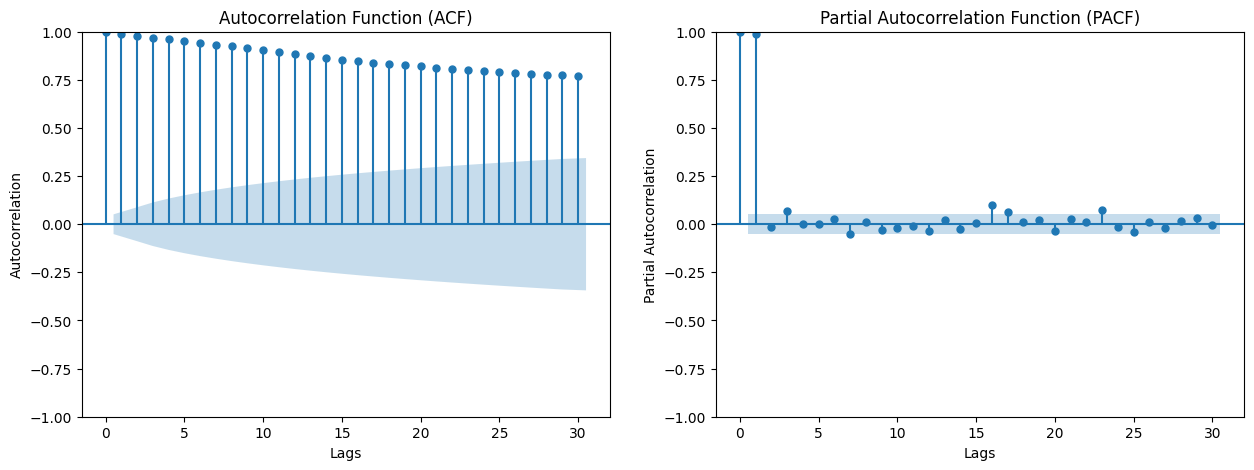

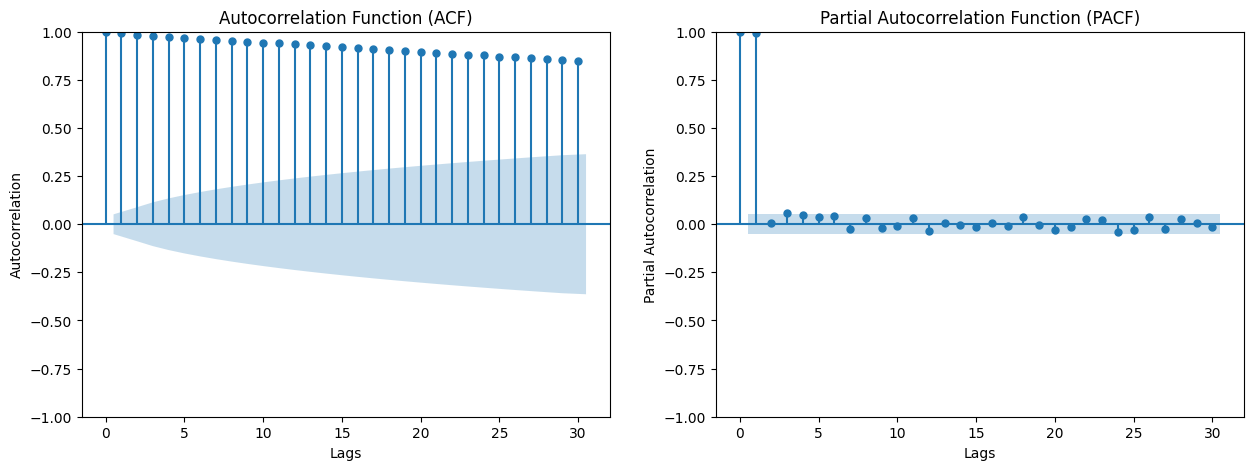

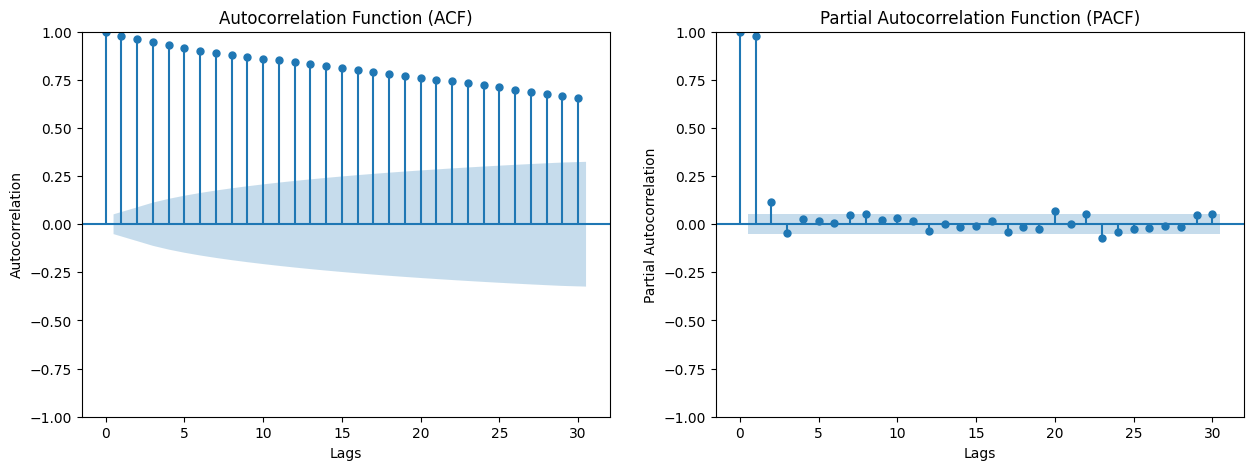

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(spread, lags=30):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(spread, lags=lags, ax=axes[0])
    plot_pacf(spread, lags=lags, ax=axes[1])
    axes[0].set_title("Autocorrelation Function (ACF)")
    axes[1].set_title("Partial Autocorrelation Function (PACF)")
    axes[0].set_xlabel("Lags")
    axes[1].set_xlabel("Lags")
    axes[0].set_ylabel("Autocorrelation")
    axes[1].set_ylabel("Partial Autocorrelation")
    plt.show()
    
for future1, future2 in selected_pairs:
    spread = get_spread_series(future1, future2)
    spread = spread.dropna() 
    plot_acf_pacf(spread)

In [32]:
def calculate_garch_volatility(residuals):
    # GARCH(1,1)
    scaled_residuals = residuals / 100.0
    am = arch_model(scaled_residuals, vol='Garch', p=1, q=1)
    res = am.fit(disp="off")
    return res.conditional_volatility * 100

In [33]:
def backtest_garch(future1, future2, initial_capital, window_size, n, ifplot=False):
    df1 = globals().get(future1.replace('.', '_') + "_df")
    df2 = globals().get(future2.replace('.', '_') + "_df")
    
    capital = initial_capital
    position = 0  
    entry_price1, entry_price2 = 0, 0  
    net_value = [capital]
    entry_points = []
    exit_points = []
    trades = []  

    residuals, spread, alpha = calculate_residuals(df1, df2)
    garch_volatility = calculate_garch_volatility(residuals)
    
    for i in range(window_size, len(residuals)):
        window_residuals = residuals.iloc[i-window_size:i]
        mean_residual = np.mean(window_residuals)
        
        current_volatility = garch_volatility.iloc[i] 
        current_residual = residuals.iloc[i]
        
        # 如果期货合约发生变化，强制平仓
        if df1['TRADE_HISCODE'].iloc[i] != df1['TRADE_HISCODE'].iloc[i-1] or df2['TRADE_HISCODE'].iloc[i] != df2['TRADE_HISCODE'].iloc[i-1]:
            if position != 0: 
                trade_profit = position * (alpha*(df1['CLOSE'].iloc[i] - entry_price1) + (entry_price2 - df2['CLOSE'].iloc[i]))
                capital += trade_profit
                exit_points.append(i)
                
                trades.append({
                    'entry_date': df1.index[entry_points[-1]],
                    'exit_date': df1.index[i],
                    'entry_price1': entry_price1,
                    'entry_price2': entry_price2,
                    'exit_price1': df1['CLOSE'].iloc[i],
                    'exit_price2': df2['CLOSE'].iloc[i],
                    'position': position,
                    'profit': trade_profit
                })
                
                position = 0
            net_value.append(capital)
            continue 
        
        # 开平仓逻辑
        if position == 0:
            if current_residual > mean_residual + n * current_volatility:
                # 做多价低，做空价高
                entry_price1, entry_price2 = df1['CLOSE'].iloc[i], df2['CLOSE'].iloc[i]
                position = 1
                entry_points.append(i)
            elif current_residual < mean_residual - n * current_volatility:
                # 做空价低，做多价高
                entry_price1, entry_price2 = df1['CLOSE'].iloc[i], df2['CLOSE'].iloc[i]
                position = -1
                entry_points.append(i)
        elif position != 0:
            if mean_residual - 0.05 * current_volatility <= current_residual <= mean_residual + 0.05 * current_volatility:
                trade_profit = position * (alpha*(df1['CLOSE'].iloc[i] - entry_price1) + (entry_price2 - df2['CLOSE'].iloc[i]))
                capital += trade_profit
                position = 0
                exit_points.append(i)
                
                trades.append({
                    'entry_date': df1.index[entry_points[-1]],
                    'exit_date': df1.index[i],
                    'entry_price1': entry_price1,
                    'entry_price2': entry_price2,
                    'exit_price1': df1['CLOSE'].iloc[i],
                    'exit_price2': df2['CLOSE'].iloc[i],
                    'position': position,
                    'profit': trade_profit
                })
            net_value.append(capital)
    
    if ifplot:
        plot_residuals_with_trades(future1, future2, window_size, n, net_value, entry_points, exit_points)
    
    return net_value, trades

In [34]:
def random_search(selected_pairs, initial_capital, window_range, n_range, num_trials=50):
    best_params = {} 
    best_performance = {} 

    for future1, future2 in selected_pairs:
        best_annual_return = -float('inf')  # 初始化最佳年化收益率
        best_combination = None

        for _ in range(num_trials):
            window_size = random.choice(window_range)
            n = round(random.choice(n_range), 2)
            net_value, trades = backtest_garch(future1, future2, initial_capital, window_size, n)
            performance = calculate_performance_metrics(net_value)
            annual_return = performance['annual_return']
            if annual_return > best_annual_return:
                best_annual_return = annual_return
                best_combination = (window_size, n)
                best_performance[(future1, future2)] = performance

        best_params[(future1, future2)] = best_combination
    
    return best_params, best_performance

n_range = np.arange(1, 5, 0.1) 
window_range = np.arange(10, 60, 5)
initial_capital = 100000

num_trials = 50  
best_params, best_performance = random_search(selected_pairs, initial_capital, window_range, n_range, num_trials)

for pair, params in best_params.items():
    print(f"\n期货对: {pair} 的最佳参数: window_size={params[0]}, n={params[1]}")
    print(f"绩效指标: 年化收益率: {best_performance[pair]['annual_return']:.2%}, "
          f"最大回撤: {best_performance[pair]['max_drawdown']:.2%}, "
          f"夏普比率: {best_performance[pair]['sharpe_ratio']:.2f}")



期货对: ('CU.SHF', 'AL.SHF') 的最佳参数: window_size=10, n=3.0
绩效指标: 年化收益率: 2.93%, 最大回撤: 1.21%, 夏普比率: -0.05

期货对: ('B.DCE', 'M.DCE') 的最佳参数: window_size=45, n=1.0
绩效指标: 年化收益率: 0.48%, 最大回撤: 0.51%, 夏普比率: -4.76

期货对: ('B.DCE', 'RM.CZC') 的最佳参数: window_size=15, n=3.7
绩效指标: 年化收益率: 0.67%, 最大回撤: 0.04%, 夏普比率: -8.66

期货对: ('P.DCE', 'Y.DCE') 的最佳参数: window_size=10, n=1.1
绩效指标: 年化收益率: 0.10%, 最大回撤: 0.92%, 夏普比率: -4.41


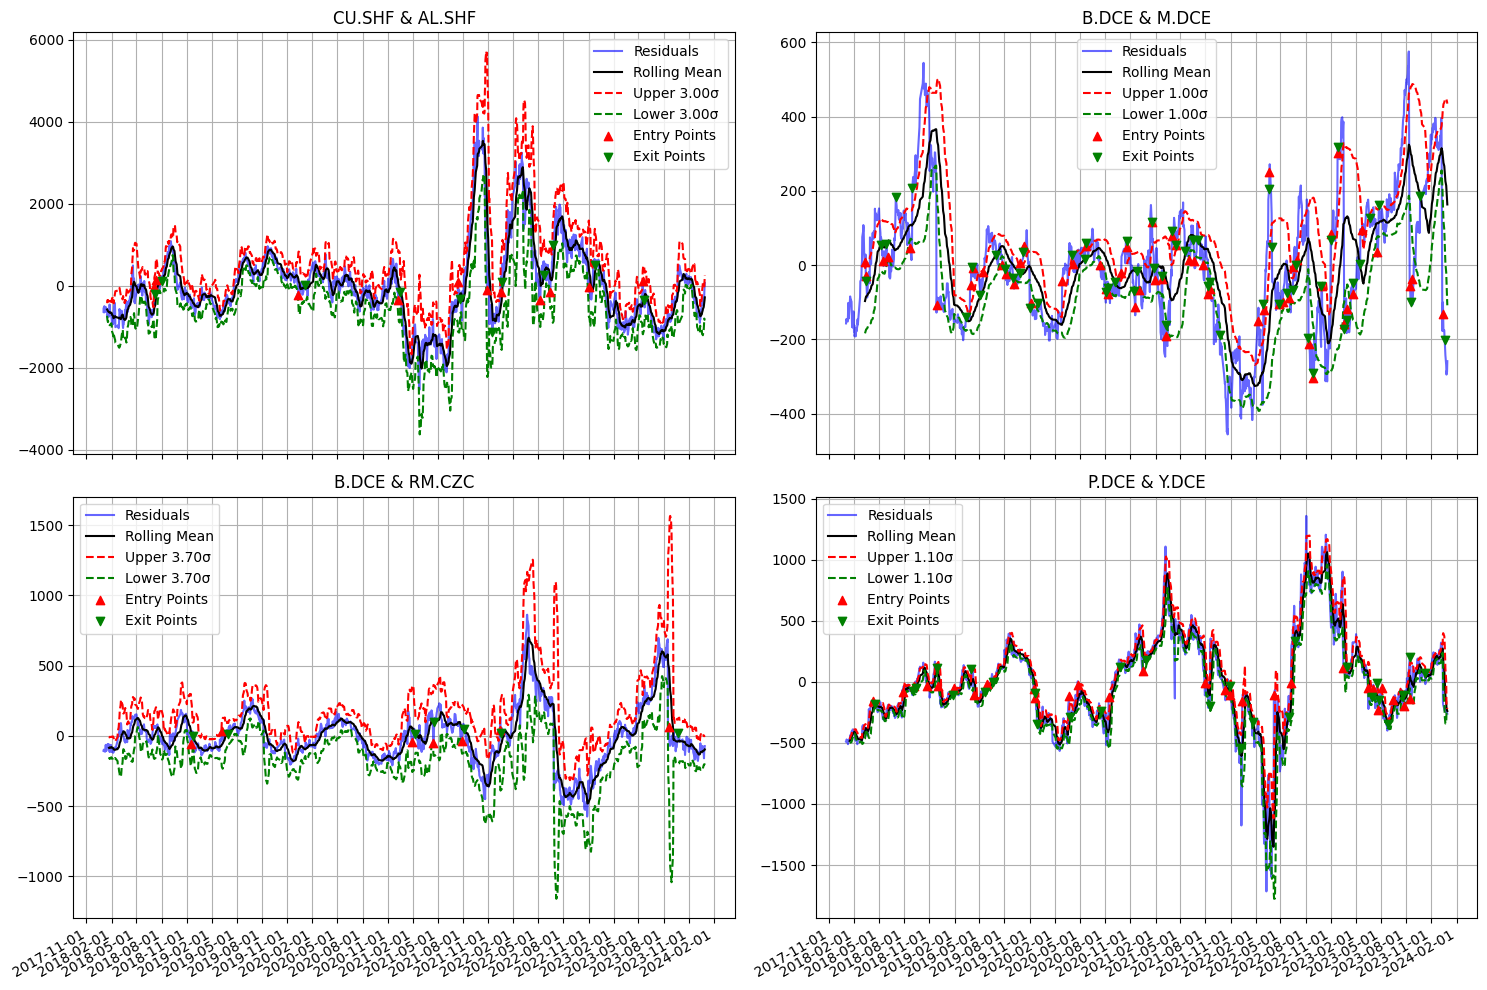

In [35]:
def run_backtest_and_plot(selected_pairs, initial_capital, best_params):
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
    axes = axes.flatten()  

    for i, (pair, params) in enumerate(best_params.items()):
        future1, future2 = pair
        window_size = params[0]
        n = params[1]
        net_value, trades = backtest_garch(future1, future2, initial_capital, window_size, n)
        df1 = globals().get(future1.replace('.', '_') + "_df")
        df2 = globals().get(future2.replace('.', '_') + "_df")
        residuals, _, _ = calculate_residuals(df1, df2)
        mean_residuals = residuals.rolling(window=window_size).mean()
        std_residuals = residuals.rolling(window=window_size).std()
        
        residuals.index = pd.to_datetime(residuals.index)

        ax = axes[i]
        ax.plot(residuals.index, residuals, label='Residuals', color='blue', alpha=0.6)
        ax.plot(residuals.index, mean_residuals, label='Rolling Mean', color='black')
        ax.plot(residuals.index, mean_residuals + n * std_residuals, 
                label=f'Upper {n:.2f}σ', color='red', linestyle='--')
        ax.plot(residuals.index, mean_residuals - n * std_residuals, 
                label=f'Lower {n:.2f}σ', color='green', linestyle='--')

        entry_points = [t['entry_date'] for t in trades]
        exit_points = [t['exit_date'] for t in trades]
        ax.scatter(entry_points, residuals.loc[entry_points], color='red', marker='^', label='Entry Points', zorder=5)
        ax.scatter(exit_points, residuals.loc[exit_points], color='green', marker='v', label='Exit Points', zorder=5)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        fig.autofmt_xdate()

        ax.set_title(f"{future1} & {future2}")
        ax.legend()
        ax.grid(True)
        
    plt.tight_layout()
    plt.show()

run_backtest_and_plot(selected_pairs, initial_capital, best_params)

## 基于基差配对交易

### 基差&价差&回归残差

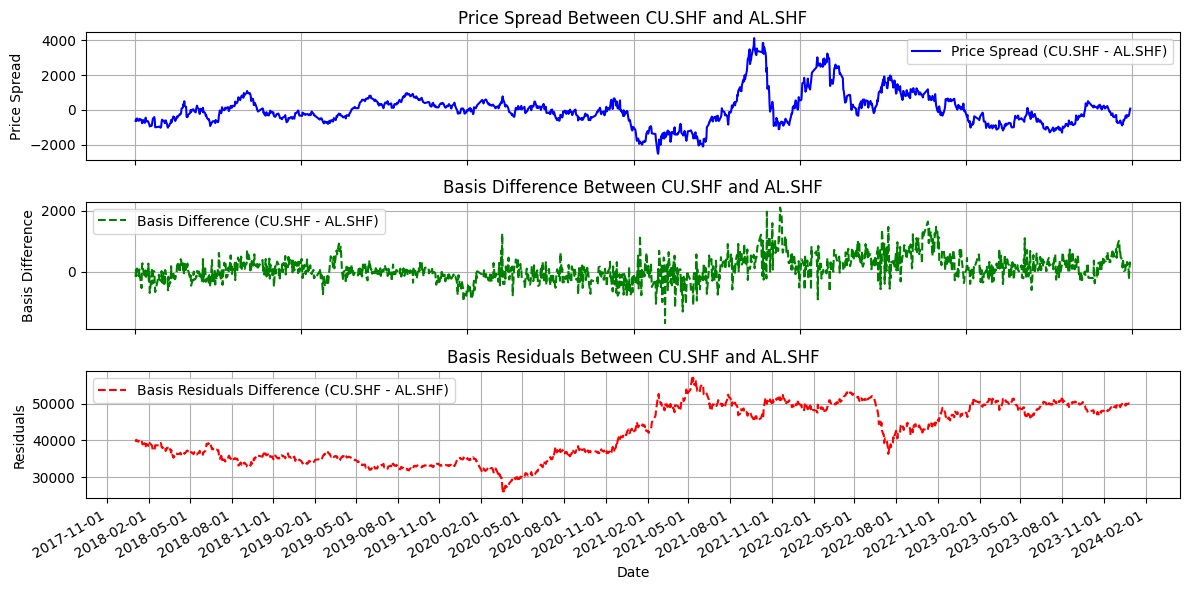

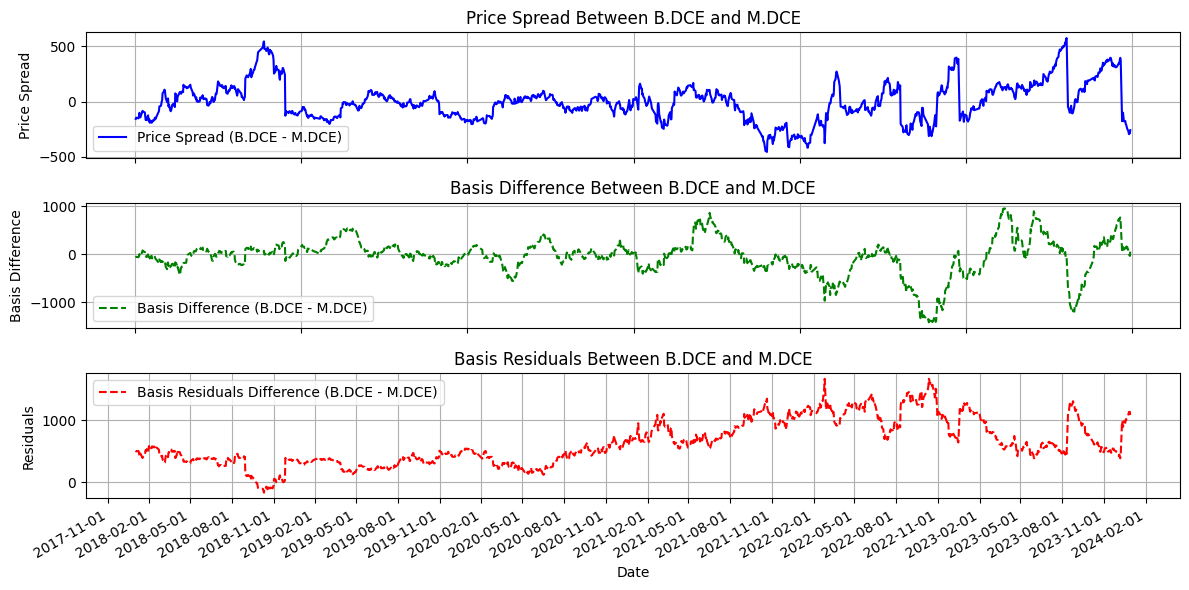

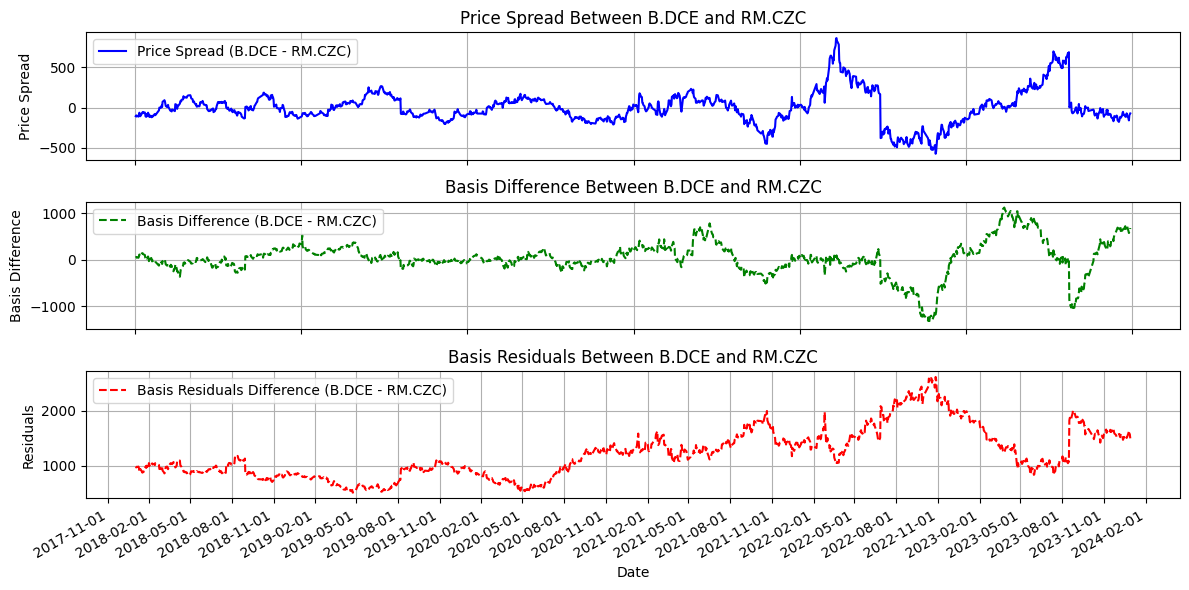

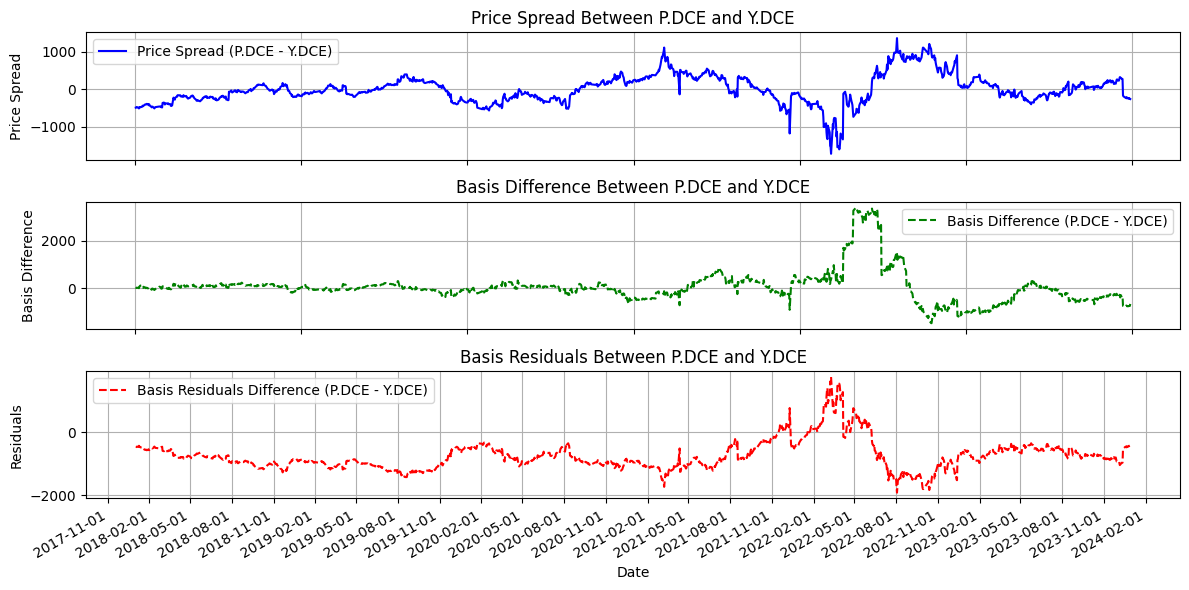

In [24]:
def plot_spread_and_basis(future1, future2, df1, df2):

    close1 = df1['CLOSE']
    close2 = df2['CLOSE']
    basis1 = df1['ANAL_BASIS']
    basis2 = df2['ANAL_BASIS']
    
    price_spread, residuals, _ = calculate_residuals(df1, df2)

    price_spread.index = pd.to_datetime(price_spread.index)
    residuals.index = pd.to_datetime(residuals.index)
    basis_diff = basis1 - basis2
    basis_diff.index = pd.to_datetime(basis_diff.index)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(price_spread.index, price_spread, label=f"Price Spread ({future1} - {future2})", color='blue')
    plt.title(f"Price Spread Between {future1} and {future2}")
    plt.xlabel("Date")
    plt.ylabel("Price Spread")
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(basis_diff.index, basis_diff, label=f"Basis Difference ({future1} - {future2})", color='green', linestyle='--')
    plt.title(f"Basis Difference Between {future1} and {future2}")
    plt.xlabel("Date")
    plt.ylabel("Basis Difference")
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(residuals.index, residuals, label=f"Basis Residuals Difference ({future1} - {future2})", color='red', linestyle='--')
    plt.title(f"Basis Residuals Between {future1} and {future2}")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.legend()
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) #每3个月输出一次
    plt.gcf().autofmt_xdate() 

    plt.tight_layout()
    plt.show()

def analyze_selected_pairs(selected_pairs):
    for future1, future2 in selected_pairs:
        df1 = globals().get(future1.replace('.', '_') + "_df")
        df2 = globals().get(future2.replace('.', '_') + "_df")
        plot_spread_and_basis(future1, future2, df1, df2)
        
analyze_selected_pairs(selected_pairs)



In [25]:
def calculate_basis_residuals(df1, df2):
    close1 = df1['ANAL_BASIS']
    close2 = df2['ANAL_BASIS']
    
    X = close1.values.reshape(-1, 1)
    y = close2.values
    
    model = LinearRegression()
    model.fit(X, y)
    predicted = model.predict(X)
    
    residuals = close2 - predicted
    slope = model.coef_[0]
      
    return residuals, close1 - close2, slope
    
def check_and_plot(futures_pairs):

    for i, (future1, future2) in enumerate(futures_pairs):
        df1 = globals().get(future1.replace('.', '_') + "_df")
        df2 = globals().get(future2.replace('.', '_') + "_df")
        
        residuals, spread, _ = calculate_basis_residuals(df1, df2)
        
        adf_p_spread = adf_test(spread) 
        adf_p_residuals = adf_test(residuals)  
        coint_p = coint_test(df1['CLOSE'], df2['CLOSE']) 

        print(f"\n{future1} 和 {future2} 的基差差的ADF检验p值: {adf_p_spread:.4f}", end=' ')
        if adf_p_spread < 0.05:
            print("(基差差平稳)")
        else:
            print("(基差差不平稳)")

        print(f"{future1} 和 {future2} 的基差回归残差的ADF检验p值: {adf_p_residuals:.4f}", end=' ')
        if adf_p_residuals < 0.05:
            print("(基差回归残差平稳)")
        else:
            print("(基差回归残差不平稳)")

        print(f"{future1} 和 {future2} 的协整检验p值: {coint_p:.4f}", end=' ')
        if coint_p < 0.05:
            print("(期货对基差序列有协整关系)")
        else:
            print("(期货对基差序列没有协整关系)")

check_and_plot(selected_pairs)


CU.SHF 和 AL.SHF 的基差差的ADF检验p值: 0.0005 (基差差平稳)
CU.SHF 和 AL.SHF 的基差回归残差的ADF检验p值: 0.0050 (基差回归残差平稳)
CU.SHF 和 AL.SHF 的协整检验p值: 0.0012 (期货对基差序列有协整关系)

B.DCE 和 M.DCE 的基差差的ADF检验p值: 0.0004 (基差差平稳)
B.DCE 和 M.DCE 的基差回归残差的ADF检验p值: 0.0031 (基差回归残差平稳)
B.DCE 和 M.DCE 的协整检验p值: 0.0016 (期货对基差序列有协整关系)

B.DCE 和 RM.CZC 的基差差的ADF检验p值: 0.0330 (基差差平稳)
B.DCE 和 RM.CZC 的基差回归残差的ADF检验p值: 0.0617 (基差回归残差不平稳)
B.DCE 和 RM.CZC 的协整检验p值: 0.0315 (期货对基差序列有协整关系)

P.DCE 和 Y.DCE 的基差差的ADF检验p值: 0.0251 (基差差平稳)
P.DCE 和 Y.DCE 的基差回归残差的ADF检验p值: 0.1583 (基差回归残差不平稳)
P.DCE 和 Y.DCE 的协整检验p值: 0.0108 (期货对基差序列有协整关系)


### 策略构建

In [26]:
def backtest_basis(future1, future2, initial_capital, window_size, n, ifplot = False):
    df1 = globals().get(future1.replace('.', '_') + "_df")
    df2 = globals().get(future2.replace('.', '_') + "_df")
    
    capital = initial_capital
    position = 0  
    entry_price1, entry_price2 = 0, 0  
    net_value = [capital]
    entry_points = []
    exit_points = []
    trades = []  

    residuals,_,_= calculate_basis_residuals(df1, df2)
    
    for i in range(window_size, len(residuals)):
        window_residuals = residuals.iloc[i-window_size:i]
        mean_residual = np.mean(window_residuals)
        std_residual = np.std(window_residuals)
        current_residual = residuals.iloc[i]
        
        # 如果期货合约发生变化，强制平仓
        if df1['TRADE_HISCODE'].iloc[i] != df1['TRADE_HISCODE'].iloc[i-1] or df2['TRADE_HISCODE'].iloc[i] != df2['TRADE_HISCODE'].iloc[i-1]:
            if position != 0: 
                trade_profit = position * ((df1['CLOSE'].iloc[i] - entry_price1) + (entry_price2 - df2['CLOSE'].iloc[i]))
                capital += trade_profit
                exit_points.append(i)
                
                trades.append({
                    'entry_date': df1.index[entry_points[-1]],
                    'exit_date': df1.index[i],
                    'entry_price1': entry_price1,
                    'entry_price2': entry_price2,
                    'exit_price1': df1['CLOSE'].iloc[i],
                    'exit_price2': df2['CLOSE'].iloc[i],
                    'position': position,
                    'profit': trade_profit
                })
                
                position = 0
            net_value.append(capital)
            continue 
        
        # 开平仓逻辑
        if position == 0:
            if current_residual > mean_residual + n * std_residual:
                # 做多价低，做空价高
                entry_price1, entry_price2 = df1['CLOSE'].iloc[i], df2['CLOSE'].iloc[i]
                position = 1
                entry_points.append(i)
            elif current_residual < mean_residual - n * std_residual:
                # 做空价低，做多价高
                entry_price1, entry_price2 = df1['CLOSE'].iloc[i], df2['CLOSE'].iloc[i]
                position = -1
                entry_points.append(i)
        elif position != 0:
            if mean_residual - 0.05 * std_residual <= current_residual <= mean_residual + 0.05 * std_residual:
                trade_profit = position * ((df1['CLOSE'].iloc[i] - entry_price1) + (entry_price2 - df2['CLOSE'].iloc[i]))
                capital += trade_profit
                position = 0
                exit_points.append(i)
                
                trades.append({
                    'entry_date': df1.index[entry_points[-1]],
                    'exit_date': df1.index[i],
                    'entry_price1': entry_price1,
                    'entry_price2': entry_price2,
                    'exit_price1': df1['CLOSE'].iloc[i],
                    'exit_price2': df2['CLOSE'].iloc[i],
                    'position': position,
                    'profit': trade_profit
                })
            net_value.append(capital)
    
    if ifplot == True:
        plot_residuals_with_trades(future1, future2, window_size, n, net_value, entry_points, exit_points)
    return net_value, trades 

In [27]:
import random

def random_search(selected_pairs, initial_capital, window_range, n_range, num_trials=50):
    best_params = {} 
    best_performance = {} 

    for future1, future2 in selected_pairs:
        best_annual_return = -float('inf')  # 初始化最佳年化收益率
        best_combination = None

        for _ in range(num_trials):
            window_size = random.choice(window_range)
            n = round(random.choice(n_range), 2)
            net_value, trades = backtest_basis(future1, future2, initial_capital, window_size, n)
            performance = calculate_performance_metrics(net_value)
            annual_return = performance['annual_return']
            if annual_return > best_annual_return:
                best_annual_return = annual_return
                best_combination = (window_size, n)
                best_performance[(future1, future2)] = performance

        best_params[(future1, future2)] = best_combination
    
    return best_params, best_performance

n_range = np.arange(1, 5, 0.1) 
window_range = np.arange(10, 60, 5)
initial_capital = 100000

num_trials = 50  
best_params, best_performance = random_search(selected_pairs, initial_capital, window_range, n_range, num_trials)

for pair, params in best_params.items():
    print(f"\n期货对: {pair} 的最佳参数: window_size={params[0]}, n={params[1]}")
    print(f"绩效指标: 年化收益率: {best_performance[pair]['annual_return']:.2%}, "
          f"最大回撤: {best_performance[pair]['max_drawdown']:.2%}, "
          f"夏普比率: {best_performance[pair]['sharpe_ratio']:.2f}")


期货对: ('CU.SHF', 'AL.SHF') 的最佳参数: window_size=10, n=2.3
绩效指标: 年化收益率: 6.47%, 最大回撤: 6.25%, 夏普比率: 0.49

期货对: ('B.DCE', 'M.DCE') 的最佳参数: window_size=15, n=2.2
绩效指标: 年化收益率: 1.25%, 最大回撤: 0.52%, 夏普比率: -2.12

期货对: ('B.DCE', 'RM.CZC') 的最佳参数: window_size=35, n=4.8
绩效指标: 年化收益率: 0.54%, 最大回撤: 0.20%, 夏普比率: -5.64

期货对: ('P.DCE', 'Y.DCE') 的最佳参数: window_size=45, n=4.5
绩效指标: 年化收益率: 1.65%, 最大回撤: 0.00%, 夏普比率: -1.93


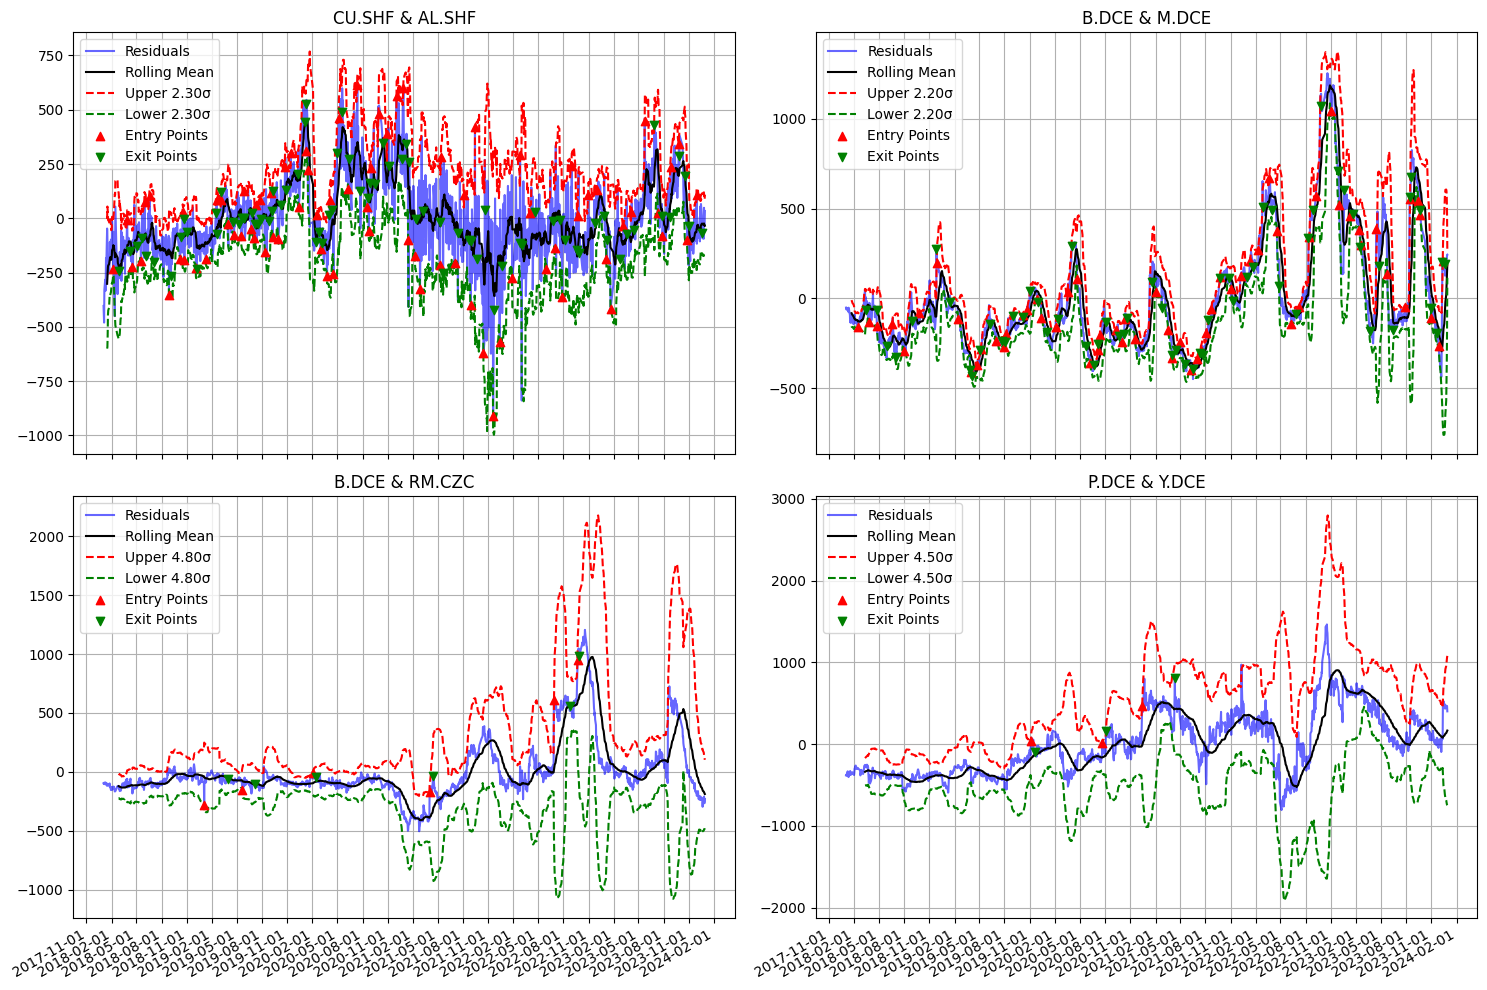

In [28]:
def run_backtest_and_plot(selected_pairs, initial_capital, best_params):
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
    axes = axes.flatten()  

    for i, (pair, params) in enumerate(best_params.items()):
        future1, future2 = pair
        window_size = params[0]
        n = params[1]
        net_value, trades = backtest_basis(future1, future2, initial_capital, window_size, n)
        df1 = globals().get(future1.replace('.', '_') + "_df")
        df2 = globals().get(future2.replace('.', '_') + "_df")
        residuals, _, _ = calculate_basis_residuals(df1, df2)
        mean_residuals = residuals.rolling(window=window_size).mean()
        std_residuals = residuals.rolling(window=window_size).std()
        
        residuals.index = pd.to_datetime(residuals.index)

        ax = axes[i]
        ax.plot(residuals.index, residuals, label='Residuals', color='blue', alpha=0.6)
        ax.plot(residuals.index, mean_residuals, label='Rolling Mean', color='black')
        ax.plot(residuals.index, mean_residuals + n * std_residuals, 
                label=f'Upper {n:.2f}σ', color='red', linestyle='--')
        ax.plot(residuals.index, mean_residuals - n * std_residuals, 
                label=f'Lower {n:.2f}σ', color='green', linestyle='--')

        entry_points = [t['entry_date'] for t in trades]
        exit_points = [t['exit_date'] for t in trades]
        ax.scatter(entry_points, residuals.loc[entry_points], color='red', marker='^', label='Entry Points', zorder=5)
        ax.scatter(exit_points, residuals.loc[exit_points], color='green', marker='v', label='Exit Points', zorder=5)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        fig.autofmt_xdate()

        ax.set_title(f"{future1} & {future2}")
        ax.legend()
        ax.grid(True)
        
    plt.tight_layout()
    plt.show()

run_backtest_and_plot(selected_pairs, initial_capital, best_params)


# ML-Pair

## LSTM

In [47]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def lstm_spread_prediction(df1, df2, window_size=50, epochs=20, batch_size=32, units=100, return_sequences=True):
    features1 = df1[['CLOSE', 'HIGH', 'LOW', 'VOLUME', 'AMT', 'PCT_CHG', 'SWING', 'OI', 'ANAL_BASIS', 'BASISANNUALYIELD']]
    features2 = df2[['CLOSE', 'HIGH', 'LOW', 'VOLUME', 'AMT', 'PCT_CHG', 'SWING', 'OI', 'ANAL_BASIS', 'BASISANNUALYIELD']]
    price_spread = (df1['CLOSE'] - df2['CLOSE']).shift(1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features1 = scaler.fit_transform(features1)
    scaled_features2 = scaler.fit_transform(features2)
    scaled_spread = scaler.fit_transform(price_spread.values.reshape(-1, 1))

    X, y = [], []
    for i in range(window_size, len(scaled_spread)):
        X.append(np.hstack((scaled_features1[i-window_size:i], scaled_features2[i-window_size:i])))
        y.append(scaled_spread[i])

    X = np.array(X)
    y = np.array(y)

    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    model = Sequential()
    model.add(LSTM(units=units, return_sequences=return_sequences, input_shape=(X_train.shape[1], X_train.shape[2])))
    if return_sequences:
        model.add(LSTM(units=units)) 
    model.add(Dense(1)) 

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predicted_spread = model.predict(X)
    predicted_spread_inversed = scaler.inverse_transform(predicted_spread)
    actual_spread = scaler.inverse_transform(y.reshape(-1, 1))

    return actual_spread, predicted_spread_inversed



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


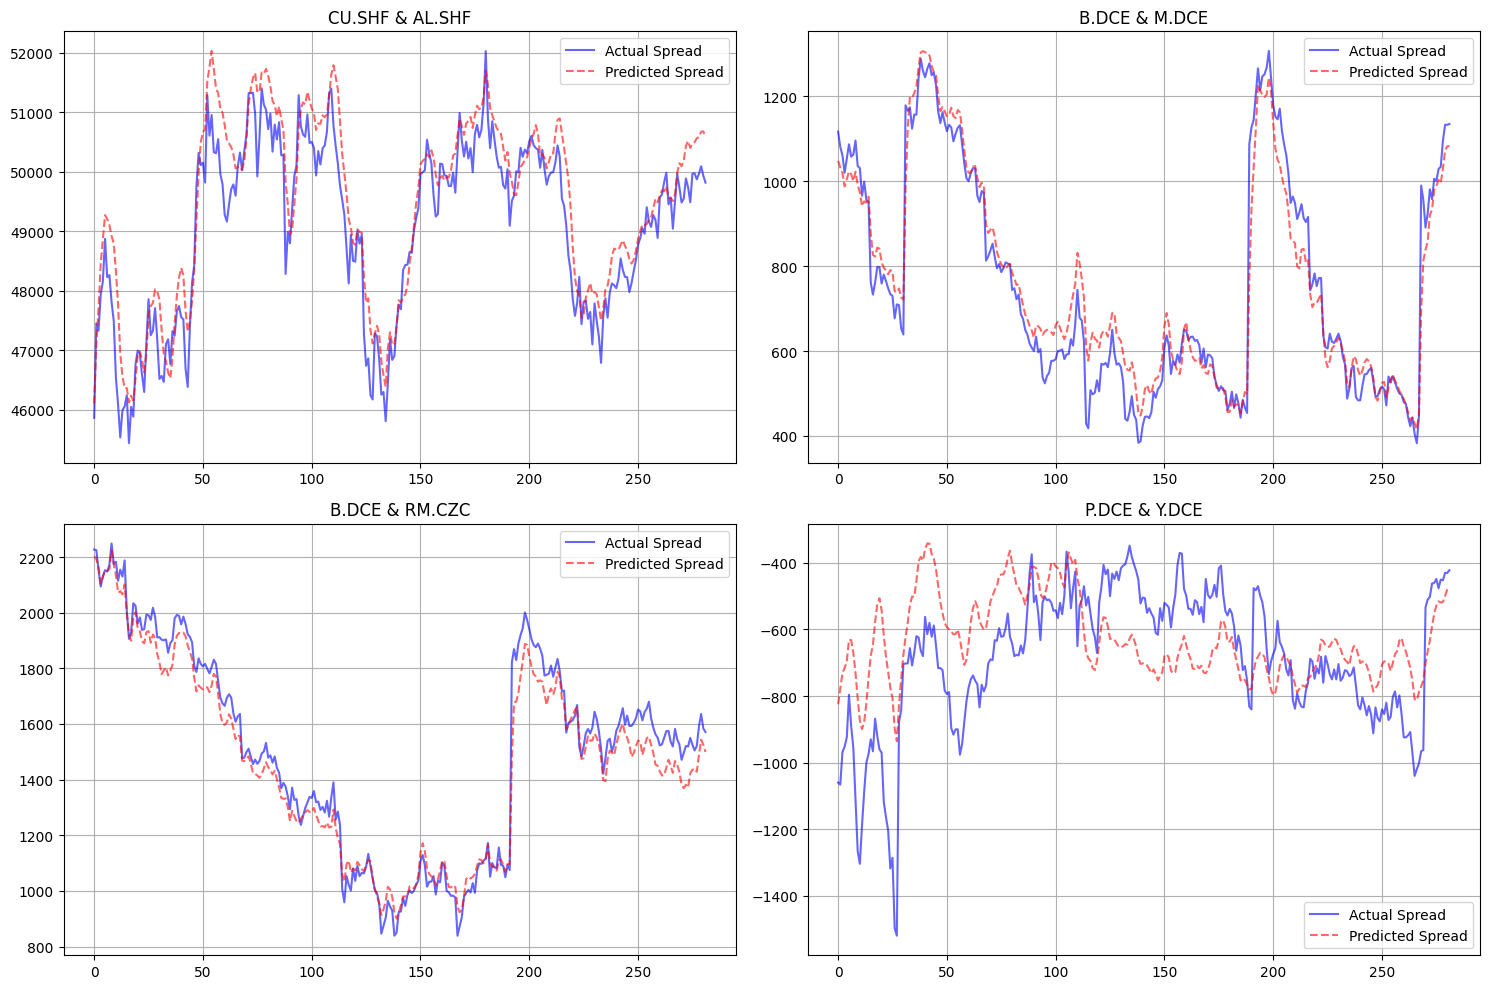

In [48]:
def lstm_spread_see(df1, df2, window_size=50, epochs=20, batch_size=32, units=100, return_sequences=True):
    features1 = df1[['CLOSE', 'HIGH', 'LOW', 'VOLUME', 'AMT', 'PCT_CHG', 'SWING', 'OI', 'ANAL_BASIS', 'BASISANNUALYIELD']]
    features2 = df2[['CLOSE', 'HIGH', 'LOW', 'VOLUME', 'AMT', 'PCT_CHG', 'SWING', 'OI', 'ANAL_BASIS', 'BASISANNUALYIELD']]
    price_spread = (df1['CLOSE'] - df2['CLOSE']).shift(1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features1 = scaler.fit_transform(features1)
    scaled_features2 = scaler.fit_transform(features2)
    scaled_spread = scaler.fit_transform(price_spread.values.reshape(-1, 1))

    X, y = [], []
    for i in range(window_size, len(scaled_spread)):
        X.append(np.hstack((scaled_features1[i-window_size:i], scaled_features2[i-window_size:i])))
        y.append(scaled_spread[i])

    X = np.array(X)
    y = np.array(y)

    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    model = Sequential()
    model.add(LSTM(units=units, return_sequences=return_sequences, input_shape=(X_train.shape[1], X_train.shape[2])))
    if return_sequences:
        model.add(LSTM(units=units)) 
    model.add(Dense(1)) 

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predicted_spread = model.predict(X_test)
    predicted_spread_inversed = scaler.inverse_transform(predicted_spread)
    actual_spread = scaler.inverse_transform(y_test.reshape(-1, 1))

    return actual_spread, predicted_spread_inversed

def plot_spread_predictions(future1, future2, actual_spread, predicted_spread, ax):
    ax.plot(actual_spread, label='Actual Spread', color='blue', alpha=0.6)
    ax.plot(predicted_spread, label='Predicted Spread', color='red', linestyle='dashed', alpha=0.6)
    ax.set_title(f'{future1} & {future2}')
    ax.legend()
    ax.grid(True)

def run_predictions_for_pairs(selected_pairs, window_size=50, epochs=20, batch_size=32, units=100):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10)) 
    axes = axes.flatten()  
    
    for idx, (future1, future2) in enumerate(selected_pairs):
        if idx >= 4:  
            break
        
        df1 = globals().get(future1.replace('.', '_') + "_df")
        df2 = globals().get(future2.replace('.', '_') + "_df")
        actual_spread, predicted_spread = lstm_spread_see(
            df1, df2, window_size=window_size, epochs=epochs, batch_size=batch_size, units=units
        )
        plot_spread_predictions(future1, future2, actual_spread, predicted_spread, axes[idx])

    plt.tight_layout() 
    plt.show()

run_predictions_for_pairs(selected_pairs, window_size=50, epochs=20, batch_size=32, units=100)

In [49]:
def backtest_with_predicted_spread(future1, future2, initial_capital, window_size, n, predicted_spread, actual_spread, ifplot=False):
    
    df1 = globals().get(future1.replace('.', '_') + "_df")
    df2 = globals().get(future2.replace('.', '_') + "_df")

    capital = initial_capital
    position = 0  
    entry_price1, entry_price2 = 0, 0  
    net_value = [capital]
    entry_points = []
    exit_points = []
    trades = []  
    
    for i in range(window_size, len(predicted_spread)):
        window_residuals = actual_spread[i-window_size:i]
        mean_residual = np.mean(window_residuals)
        std_residual = np.std(window_residuals)
        current_residual = predicted_spread[i]
        
        # 如果期货合约发生变化，强制平仓
        if df1['TRADE_HISCODE'].iloc[i] != df1['TRADE_HISCODE'].iloc[i-1] or df2['TRADE_HISCODE'].iloc[i] != df2['TRADE_HISCODE'].iloc[i-1]:
            if position != 0: 
                trade_profit = position * ((df1['CLOSE'].iloc[i] - entry_price1) + (entry_price2 - df2['CLOSE'].iloc[i])) 
                capital += trade_profit
                exit_points.append(i)
                
                trades.append({
                    'entry_date': df1.index[entry_points[-1]],
                    'exit_date': df1.index[i],
                    'entry_price1': entry_price1,
                    'entry_price2': entry_price2,
                    'exit_price1': df1['CLOSE'].iloc[i],
                    'exit_price2': df2['CLOSE'].iloc[i],
                    'position': position,
                    'profit': trade_profit
                })
                
                position = 0
            net_value.append(capital)
            continue 
        
        # 开平仓逻辑
        if position == 0:
            if current_residual > mean_residual + n * std_residual:
                # 做多价低，做空价高
                entry_price1, entry_price2 = df1['CLOSE'].iloc[i], df2['CLOSE'].iloc[i]
                position = 1
                entry_points.append(i)
            elif current_residual < mean_residual - n * std_residual:
                # 做空价低，做多价高
                entry_price1, entry_price2 = df1['CLOSE'].iloc[i], df2['CLOSE'].iloc[i]
                position = -1
                entry_points.append(i)
        elif position != 0:
            if mean_residual - 0.05 * std_residual <= current_residual <= mean_residual + 0.05 * std_residual:
                trade_profit = position * ((df1['CLOSE'].iloc[i] - entry_price1) + (entry_price2 - df2['CLOSE'].iloc[i])) 
                capital += trade_profit
                position = 0
                exit_points.append(i)
                
                trades.append({
                    'entry_date': df1.index[entry_points[-1]],
                    'exit_date': df1.index[i],
                    'entry_price1': entry_price1,
                    'entry_price2': entry_price2,
                    'exit_price1': df1['CLOSE'].iloc[i],
                    'exit_price2': df2['CLOSE'].iloc[i],
                    'position': position,
                    'profit': trade_profit
                })
            net_value.append(capital)
    
    if ifplot:
        plot_residuals_with_trades(future1, future2, window_size, n, net_value, entry_points, exit_points)
    return net_value, trades


In [54]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

def random_search_optimization(selected_pairs, initial_capital, window_range, n_range, num_trials=50):
    best_params = {}
    best_performance = {}

    total_iterations = len(selected_pairs) * num_trials
    with tqdm(total=total_iterations, desc="Optimization Progress") as pbar:
        for future1, future2 in selected_pairs:
            best_combination = None
            best_metrics = None
            
            df1 = globals().get(future1.replace('.', '_') + "_df")
            df2 = globals().get(future2.replace('.', '_') + "_df")
            actual_spread, predicted_spread = lstm_spread_prediction(df1, df2)

            for _ in range(num_trials):
                window_size = random.choice(window_range)
                n = random.choice(n_range)

                net_value, trades = backtest_with_predicted_spread(
                    future1, future2, initial_capital, window_size, n, 
                    predicted_spread, actual_spread
                )
                performance = calculate_performance_metrics(net_value)

                if best_metrics is None or performance['annual_return'] > best_metrics['annual_return']:
                    best_combination = (window_size, n)
                    best_metrics = performance
                    best_metrics['net_value'] = net_value[-1]
                    best_metrics['trades'] = len(trades)

                pbar.update(1) 

            best_params[(future1, future2)] = best_combination
            best_performance[(future1, future2)] = best_metrics

    return best_params, best_performance

window_range = list(range(10, 60, 5))
n_range = list(np.arange(1, 5, 0.1))

best_params, best_performance = random_search_optimization(
    selected_pairs, initial_capital=100000, window_range=window_range, n_range=n_range, num_trials=50
)

for pair, params in best_params.items():
    performance = best_performance[pair]
    print(f"{pair[0]} & {pair[1]} 最佳参数: window={params[0]}, n={params[1]:.1f}, "
          f"年化收益率: {performance['annual_return']:.2%}, "
          f"最大回撤: {performance['max_drawdown']:.2%}, "
          f"夏普比率: {performance['sharpe_ratio']:.2f}, "
          f"交易次数: {performance['trades']}")


Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Optimization Progress:  24%|██▍       | 49/200 [00:16<00:08, 18.55it/s]

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


Optimization Progress:  50%|█████     | 100/200 [00:44<00:05, 19.08it/s]

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Optimization Progress:  75%|███████▌  | 150/200 [00:48<00:02, 18.16it/s]

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


Optimization Progress: 100%|██████████| 200/200 [01:05<00:00,  3.04it/s]

CU.SHF & AL.SHF 最佳参数: window=45, n=3.5, 年化收益率: 3.75%, 最大回撤: 0.97%, 夏普比率: 0.22, 交易次数: 3
B.DCE & M.DCE 最佳参数: window=40, n=2.5, 年化收益率: 0.57%, 最大回撤: 0.25%, 夏普比率: -6.22, 交易次数: 14
B.DCE & RM.CZC 最佳参数: window=15, n=3.3, 年化收益率: 1.11%, 最大回撤: 0.45%, 夏普比率: -2.64, 交易次数: 12
P.DCE & Y.DCE 最佳参数: window=35, n=2.7, 年化收益率: 3.22%, 最大回撤: 0.10%, 夏普比率: 0.11, 交易次数: 12


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


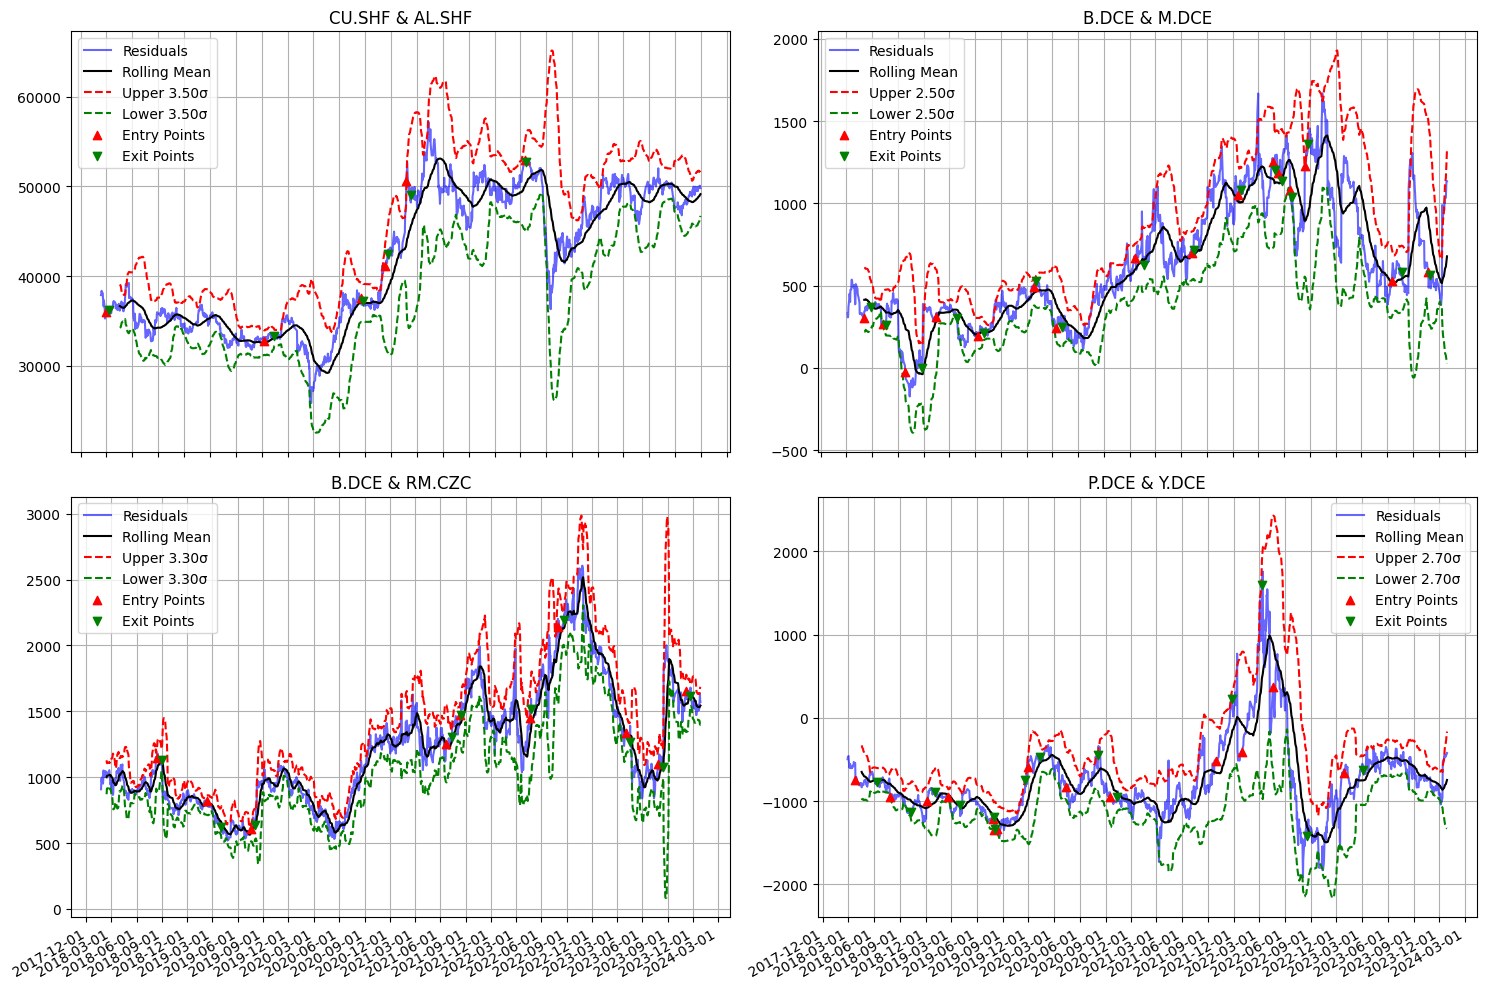

In [55]:
def run_backtest_and_plot(selected_pairs, initial_capital, best_params):

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
    axes = axes.flatten() 

    for i, (pair, params) in enumerate(best_params.items()):
        future1, future2 = pair
        window_size = params[0]
        n = params[1]

        df1 = globals().get(future1.replace('.', '_') + "_df")
        df2 = globals().get(future2.replace('.', '_') + "_df")

        actual_spread, predicted_spread = lstm_spread_prediction(
            df1, df2, window_size=window_size
        )

        net_value, trades = backtest_with_predicted_spread(
            future1, future2, initial_capital, window_size, n, 
            predicted_spread, actual_spread
        )

        residuals = pd.Series(actual_spread.flatten(), index=df1.index[-len(actual_spread):])
        mean_residuals = residuals.rolling(window=window_size).mean()
        std_residuals = residuals.rolling(window=window_size).std()

        residuals.index = pd.to_datetime(residuals.index)
        ax = axes[i]
        ax.plot(residuals.index, residuals, label='Residuals', color='blue', alpha=0.6)
        ax.plot(residuals.index, mean_residuals, label='Rolling Mean', color='black')
        ax.plot(residuals.index, mean_residuals + n * std_residuals, 
                label=f'Upper {n:.2f}σ', color='red', linestyle='--')
        ax.plot(residuals.index, mean_residuals - n * std_residuals, 
                label=f'Lower {n:.2f}σ', color='green', linestyle='--')

        entry_points = [t['entry_date'] for t in trades]
        exit_points = [t['exit_date'] for t in trades]
        ax.scatter(entry_points, residuals.loc[entry_points], color='red', marker='^', label='Entry Points', zorder=5)
        ax.scatter(exit_points, residuals.loc[exit_points], color='green', marker='v', label='Exit Points', zorder=5)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
        fig.autofmt_xdate() 

        ax.set_title(f"{future1} & {future2}")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

run_backtest_and_plot(selected_pairs, initial_capital=1000000, best_params=best_params)

## XGBOOST

In [58]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

def xgboost_spread_prediction(df1, df2, window_size=50, test_size=0.2):
    features1 = df1[['CLOSE', 'HIGH', 'LOW', 'VOLUME', 'AMT', 'PCT_CHG', 'SWING', 'OI', 'ANAL_BASIS', 'BASISANNUALYIELD']]
    features2 = df2[['CLOSE', 'HIGH', 'LOW', 'VOLUME', 'AMT', 'PCT_CHG', 'SWING', 'OI', 'ANAL_BASIS', 'BASISANNUALYIELD']]
    
    price_spread_now, _, alpha = calculate_residuals(df1, df2)
    price_spread = price_spread_now.shift(1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features1 = scaler.fit_transform(features1)
    scaled_features2 = scaler.fit_transform(features2)
    scaled_spread = scaler.fit_transform(price_spread.values.reshape(-1, 1))

    X, y = [], []
    for i in range(window_size, len(scaled_spread)):
        X.append(np.hstack((scaled_features1[i-window_size:i], scaled_features2[i-window_size:i])))
        y.append(scaled_spread[i])

    X = np.array(X)
    X = X.reshape(X.shape[0], -1)  
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
    model.fit(X_train, y_train)
    predicted_spread = model.predict(X_test)

    predicted_spread_inversed = scaler.inverse_transform(predicted_spread.reshape(-1, 1))
    actual_spread = scaler.inverse_transform(y_test.reshape(-1, 1))

    all_predicted = model.predict(X)
    all_predicted_inversed = scaler.inverse_transform(all_predicted.reshape(-1, 1))
    all_actual = scaler.inverse_transform(y.reshape(-1, 1))

    return all_actual, all_predicted_inversed

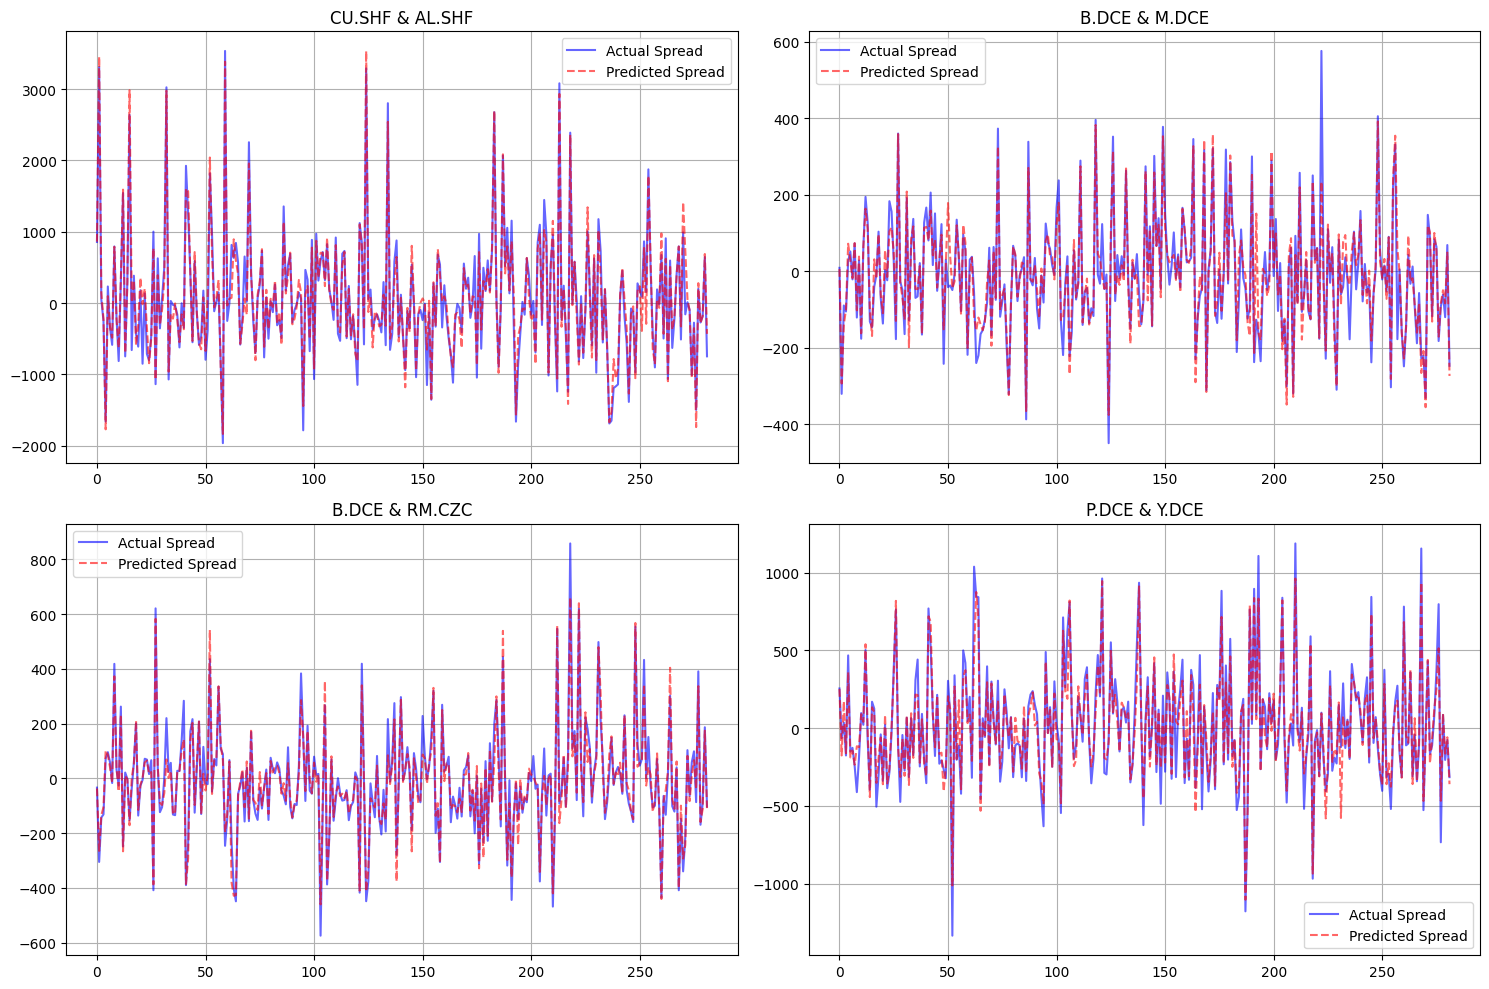

In [44]:
def xgboost_spread_see(df1, df2, window_size=50, test_size=0.2):
    features1 = df1[['CLOSE', 'HIGH', 'LOW', 'VOLUME', 'AMT', 'PCT_CHG', 'SWING', 'OI', 'ANAL_BASIS', 'BASISANNUALYIELD']]
    features2 = df2[['CLOSE', 'HIGH', 'LOW', 'VOLUME', 'AMT', 'PCT_CHG', 'SWING', 'OI', 'ANAL_BASIS', 'BASISANNUALYIELD']]
    
    price_spread_now, _, alpha = calculate_residuals(df1, df2)
    price_spread = price_spread_now.shift(1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features1 = scaler.fit_transform(features1)
    scaled_features2 = scaler.fit_transform(features2)
    scaled_spread = scaler.fit_transform(price_spread.values.reshape(-1, 1))

    X, y = [], []
    for i in range(window_size, len(scaled_spread)):
        X.append(np.hstack((scaled_features1[i-window_size:i], scaled_features2[i-window_size:i])))
        y.append(scaled_spread[i])

    X = np.array(X)
    X = X.reshape(X.shape[0], -1)  
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
    model.fit(X_train, y_train)
    predicted_spread = model.predict(X_test)

    predicted_spread_inversed = scaler.inverse_transform(predicted_spread.reshape(-1, 1))
    actual_spread = scaler.inverse_transform(y_test.reshape(-1, 1))

    all_predicted = model.predict(X)
    all_predicted_inversed = scaler.inverse_transform(all_predicted.reshape(-1, 1))
    all_actual = scaler.inverse_transform(y.reshape(-1, 1))

    return actual_spread, predicted_spread_inversed

def run_predictions_for_pairs(selected_pairs, window_size=50, epochs=20, batch_size=32, units=100):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10)) 
    axes = axes.flatten()  
    
    for idx, (future1, future2) in enumerate(selected_pairs):
        if idx >= 4: 
            break
        
        df1 = globals().get(future1.replace('.', '_') + "_df")
        df2 = globals().get(future2.replace('.', '_') + "_df")
        actual_spread, predicted_spread = xgboost_spread_see(
            df1, df2, window_size=window_size, test_size=0.2
        )
        plot_spread_predictions(future1, future2, actual_spread, predicted_spread, axes[idx])

    plt.tight_layout() 
    plt.show()

run_predictions_for_pairs(selected_pairs, window_size=50, epochs=20, batch_size=32, units=100)

In [66]:
import random
from tqdm import tqdm

def random_search_optimization(selected_pairs, initial_capital, window_range, n_range, num_trials=50):
    best_params = {}  
    best_performance = {}  

    total_iterations = len(selected_pairs) * num_trials
    with tqdm(total=total_iterations, desc="Optimization Progress") as pbar:
        for future1, future2 in selected_pairs:
            best_combination = None
            best_metrics = None
            
            # XGBoost prediction
            actual_spread, predicted_spread = xgboost_spread_prediction(
                df1=globals().get(future1.replace('.', '_') + "_df"),
                df2=globals().get(future2.replace('.', '_') + "_df"),
                window_size=random.choice(window_range)
            )

            for _ in range(num_trials):
                window_size = random.choice(window_range)
                n = random.choice(n_range)

                net_value, trades = backtest_with_predicted_spread(
                    future1, future2, initial_capital, window_size, n, 
                    predicted_spread, actual_spread
                )
                performance = calculate_performance_metrics(net_value)

                if best_metrics is None or performance['annual_return'] > best_metrics['annual_return']:
                    best_combination = (window_size, n)
                    best_metrics = performance
                    best_metrics['net_value'] = net_value[-1]
                    best_metrics['trades'] = len(trades)

                pbar.update(1) 

            best_params[(future1, future2)] = best_combination
            best_performance[(future1, future2)] = best_metrics

    return best_params, best_performance

window_range = list(range(10, 60, 5))
n_range = list(np.arange(1, 5, 0.1))

best_params, best_performance = random_search_optimization(
    selected_pairs, initial_capital=100000, window_range=window_range, n_range=n_range, num_trials=50
)

for pair, params in best_params.items():
    performance = best_performance[pair]
    print(f"{pair[0]} & {pair[1]} 最佳参数: window={params[0]}, n={params[1]:.1f}, "
          f"年化收益率: {performance['annual_return']:.2%}, "
          f"最大回撤: {performance['max_drawdown']:.2%}, "
          f"夏普比率: {performance['sharpe_ratio']:.2f}, "
          f"交易次数: {performance['trades']}")


Optimization Progress: 100%|██████████| 200/200 [00:19<00:00, 10.23it/s]

CU.SHF & AL.SHF 最佳参数: window=45, n=3.9, 年化收益率: 5.77%, 最大回撤: 0.00%, 夏普比率: 0.91, 交易次数: 2
B.DCE & M.DCE 最佳参数: window=10, n=3.1, 年化收益率: 0.65%, 最大回撤: 1.25%, 夏普比率: -2.45, 交易次数: 40
B.DCE & RM.CZC 最佳参数: window=10, n=3.9, 年化收益率: 0.34%, 最大回撤: 0.37%, 夏普比率: -5.40, 交易次数: 33
P.DCE & Y.DCE 最佳参数: window=35, n=4.9, 年化收益率: 0.00%, 最大回撤: 0.00%, 夏普比率: -139444278051114352.00, 交易次数: 0


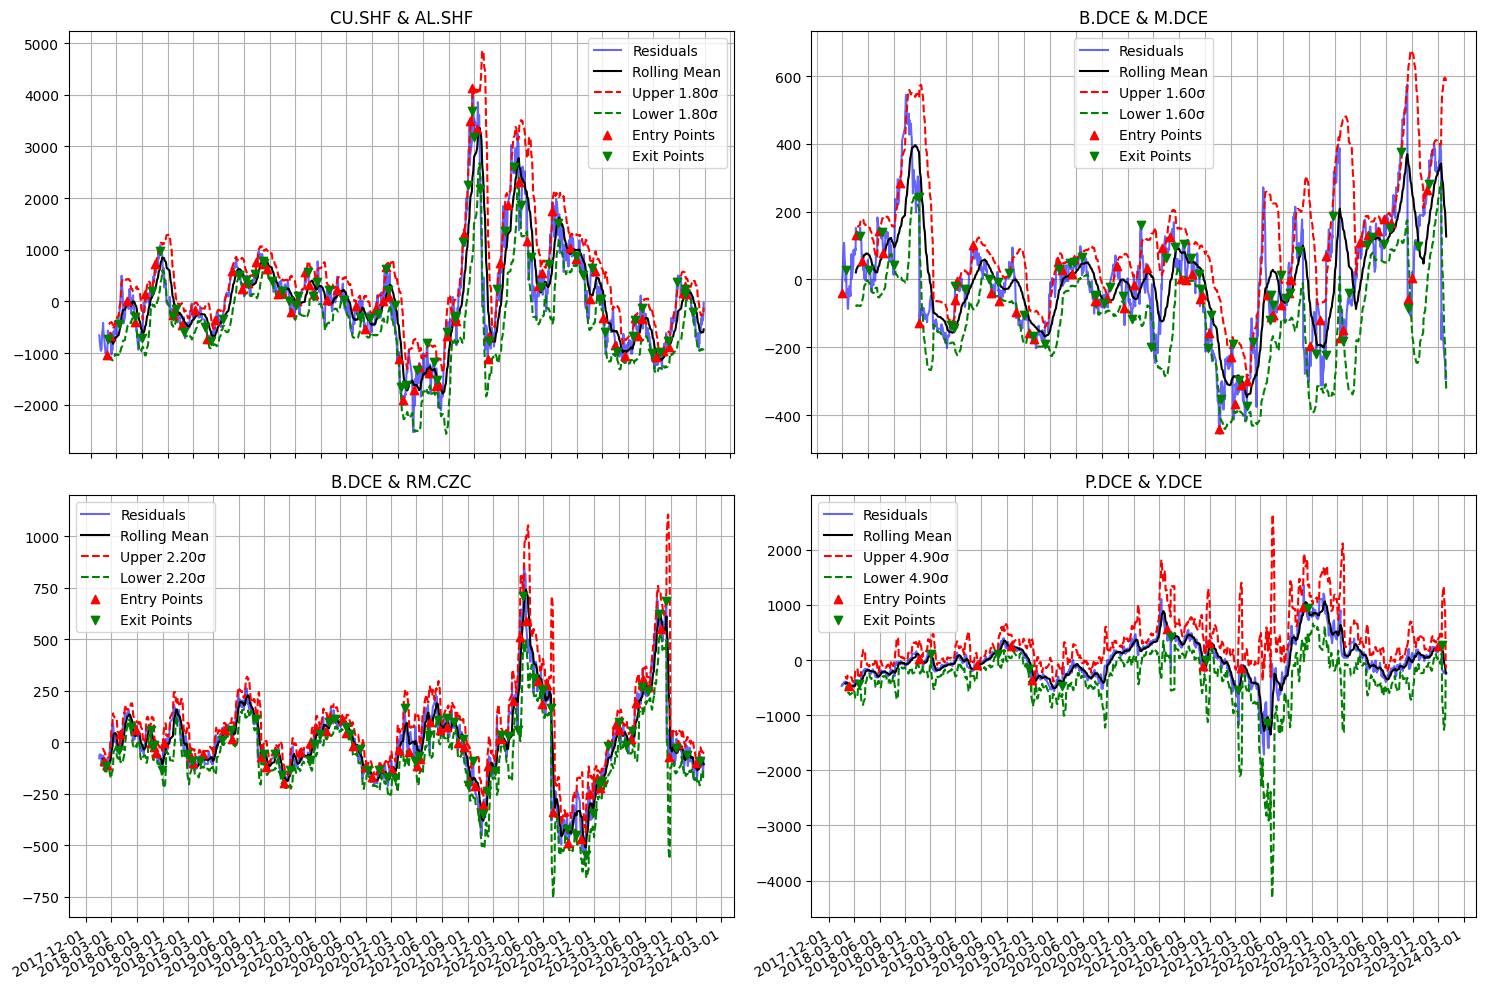

In [46]:
def run_backtest_and_plot(selected_pairs, initial_capital, best_params):

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
    axes = axes.flatten() 

    for i, (pair, params) in enumerate(best_params.items()):
        future1, future2 = pair
        window_size = params[0]
        n = params[1]

        df1 = globals().get(future1.replace('.', '_') + "_df")
        df2 = globals().get(future2.replace('.', '_') + "_df")

        actual_spread, predicted_spread = xgboost_spread_prediction(
            df1, df2, window_size=window_size
        )

        net_value, trades = backtest_with_predicted_spread(
            future1, future2, initial_capital, window_size, n, 
            predicted_spread, actual_spread
        )

        residuals = pd.Series(actual_spread.flatten(), index=df1.index[-len(actual_spread):])
        mean_residuals = residuals.rolling(window=window_size).mean()
        std_residuals = residuals.rolling(window=window_size).std()

        residuals.index = pd.to_datetime(residuals.index)
        ax = axes[i]
        ax.plot(residuals.index, residuals, label='Residuals', color='blue', alpha=0.6)
        ax.plot(residuals.index, mean_residuals, label='Rolling Mean', color='black')
        ax.plot(residuals.index, mean_residuals + n * std_residuals, 
                label=f'Upper {n:.2f}σ', color='red', linestyle='--')
        ax.plot(residuals.index, mean_residuals - n * std_residuals, 
                label=f'Lower {n:.2f}σ', color='green', linestyle='--')

        entry_points = [t['entry_date'] for t in trades]
        exit_points = [t['exit_date'] for t in trades]
        ax.scatter(entry_points, residuals.loc[entry_points], color='red', marker='^', label='Entry Points', zorder=5)
        ax.scatter(exit_points, residuals.loc[exit_points], color='green', marker='v', label='Exit Points', zorder=5)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
        fig.autofmt_xdate() 

        ax.set_title(f"{future1} & {future2}")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

run_backtest_and_plot(selected_pairs, initial_capital=1000000, best_params=best_params)